In [ ]:
### TOMORROW:
# Start training, including visit counts
# Check that augmentor works well for visit counts as well
# Change the save format and load format for valid and train

In [10]:
# todo
# look into increasing network size and comparing ability then
# change the lr to be a schedule that goes up and down, maybe just with sgd
# really, want the network to have a 100% hit on 1 move wins?

from importlib import reload
import random
import torch
import os
import numpy as np
import copy
from pathlib import Path
import matplotlib.pyplot as plt
import datetime
import pickle

import trainer
reload(trainer)

import mcts.networks
reload(mcts.networks)

import augmentor
reload(augmentor)

from trainer import PatternTrainer
from mcts.networks import PatternsNet
from plotting import PatternPlotter
from augmentor import StateAugmentor

my_device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# rseed = 12387623
# random.seed(rseed)
# torch.manual_seed(rseed)
# np.random.seed(rseed)


In [ ]:
### get saved game files in location:

# _lstrings = [
#     '2025_07_01_23_03',
#     '2025_07_01_23_23',
#             ]

load_dir = os.path.join(Path.cwd(), 'saved_games', 'v3', 'train')
saved_games = os.listdir(load_dir)
rgame = random.choice(saved_games)
_games = pickle.load(open(os.path.join(load_dir, rgame), 'rb'))
# saved_games = pickle.load(open(load_string, 'rb'))
# len(saved_games[-1]), len(saved_games[0]), len(saved_games[1])

In [11]:
### get saved game files in location:

load_dir = os.path.join(Path.cwd(), 'saved_games', 'search_v1')
saved_games = os.listdir(load_dir)
rgame = random.choice(saved_games)
_games = pickle.load(open(os.path.join(load_dir, rgame), 'rb'))


In [24]:
g1, g2, g3 = _games[1][999], _games[1][1000], _games[1][1001]





In [28]:
g2[0][24:30, 0, 0]

tensor([0.3333, 0.1667, 0.6667, 0.8333, 0.5000, 0.0000])

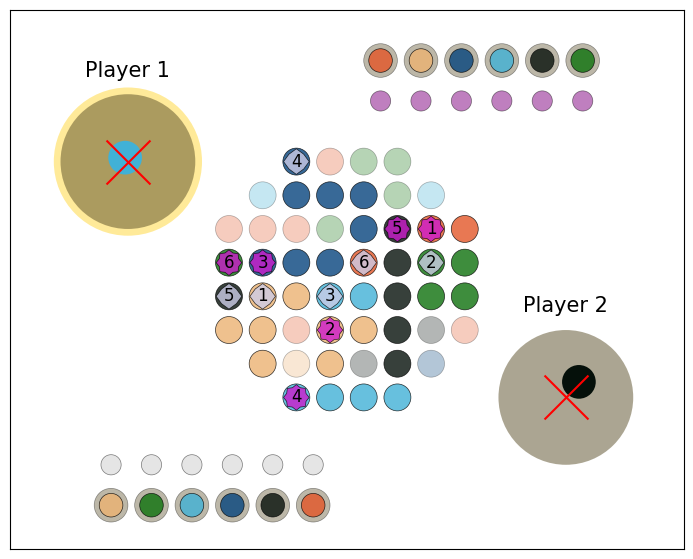

(64, 50)


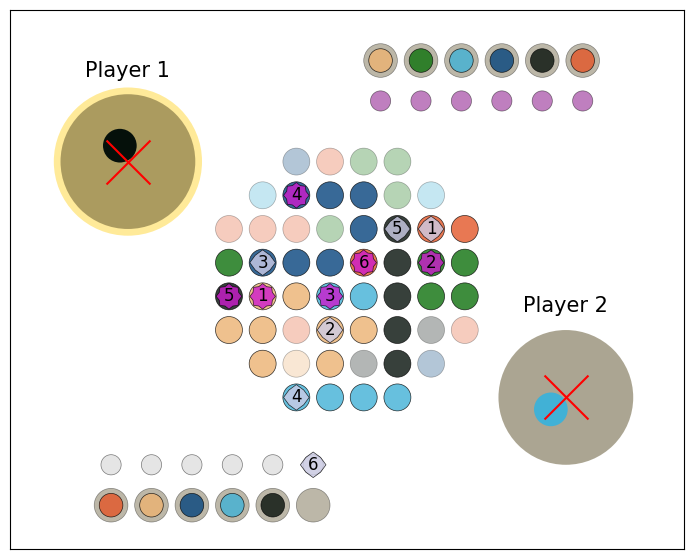

(46, 58)


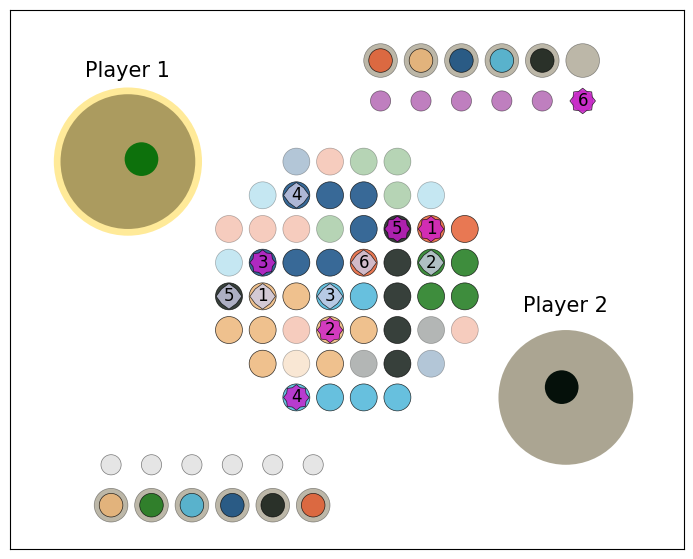

(58, 46)


In [29]:
new_games = []
for game in [g1, g2, g3]:
    paug = StateAugmentor(game[0])
    new_game = paug.create_game_from_state()
    pplotter = PatternPlotter(new_game)
    pplotter.plot()
    print(new_game.calculate_score())
    new_games.append(new_game)

In [34]:
from int_to_board import loci, locj

In [40]:
new_games[1].passive_color_groups

{0: [(5, 3), (5, 4), (6, 3)],
 1: [(2, 6), (2, 7)],
 2: [(7, 2), (7, 3), (7, 4), (7, 5)],
 3: [(2, 5), (3, 5), (4, 5), (5, 5), (6, 5)],
 4: [(3, 1), (3, 2), (3, 3)],
 5: []}

In [47]:
game = copy.deepcopy(new_games[2])
action = 18

board = np.array(game.passive_board)

active_token = game.passive_bowl_token
passive_token = game.active_bowl_token

print(active_token, passive_token)

# active and passive reversed to represent the swap in players after action:
active_order = game.passive_color_order[:]
passive_order = game.active_color_order[:]

print(active_order, passive_order)

# also get the color groups:
active_color_groups = {_key: _val[:] for _key, _val in game.passive_color_groups.items()}
passive_color_groups = {_key: _val[:] for _key, _val in game.active_color_groups.items()}

print(active_color_groups, passive_color_groups)

# remaining actions represent a change to the board state:
location = action % 52
coords = loci[location], locj[location]

# update the relevant color group with the coordinates of the flipped location:
cg_update_color = passive_token if action < 52 else board[coords]
passive_color_groups[cg_update_color].append(coords)

print(cg_update_color, passive_color_groups)

# the passive token becomes the color at the location, the new location gets the COLOR of the passive token:
if action < 52:
    new_token = board[coords]
    board[coords] = passive_token
    passive_token = new_token

# Whether flipping or placing, the location takes on the +12 of the passive player:
board[coords] += 12

# only the passive order can be updated...
if not game.active_color_groups[game.active_bowl_token]:
    passive_order[game.active_bowl_token] = game.active_placing_number

print(passive_order)

3 5
[1, 6, 3, 5, 4, 2] [2, 1, 4, 5, 3, 0]
{0: [(4, 1), (4, 2), (5, 0), (5, 1), (6, 1)], 1: [(3, 4)], 2: [(4, 3), (4, 4)], 3: [(4, 0)], 4: [(1, 2), (1, 3), (1, 4), (2, 4)], 5: [(3, 6), (3, 7), (4, 6), (4, 7)]} {0: [(5, 3), (5, 4), (6, 3)], 1: [(2, 6), (2, 7)], 2: [(7, 2), (7, 3), (7, 4), (7, 5)], 3: [(2, 5), (3, 5), (4, 5), (5, 5), (6, 5)], 4: [(3, 1), (3, 2), (3, 3)], 5: []}
5 {0: [(5, 3), (5, 4), (6, 3)], 1: [(2, 6), (2, 7)], 2: [(7, 2), (7, 3), (7, 4), (7, 5)], 3: [(2, 5), (3, 5), (4, 5), (5, 5), (6, 5)], 4: [(3, 1), (3, 2), (3, 3)], 5: [(3, 0)]}
[2, 1, 4, 5, 3, 6]


In [46]:
if not game.active_color_groups[game.active_bowl_token]:
    passive_order[game.active_bowl_token] = game.active_placing_number

[]

In [42]:
passive_color_groups, active_color_groups

({0: [(5, 3), (5, 4), (6, 3)],
  1: [(2, 6), (2, 7)],
  2: [(7, 2), (7, 3), (7, 4), (7, 5)],
  3: [(2, 5), (3, 5), (4, 5), (5, 5), (6, 5)],
  4: [(3, 1), (3, 2), (3, 3)],
  5: [(3, 0)]},
 {0: [(4, 1), (4, 2), (5, 0), (5, 1), (6, 1)],
  1: [(3, 4)],
  2: [(4, 3), (4, 4)],
  3: [(4, 0)],
  4: [(1, 2), (1, 3), (1, 4), (2, 4)],
  5: [(3, 6), (3, 7), (4, 6), (4, 7)]})

In [32]:
sorted(game.get_actions())

[0, 1, 2, 3, 4, 8, 9, 10, 11, 12, 13, 18, 36, 43, 45, 47, 92, 97]

In [14]:
len(_games[0]), len(_games[1]), len(_games[-1])


(450, 1998, 624)

In [ ]:
### Testing for the augmentor:

_check = random.choice(_games[-1])

check_tensor = _check[0]
check_visit_counts = _check[1]
check_distance_from_terminal = _check[2]
check_flipped = _check[3]
check_nod_result = _check[4]


where_vcs = np.where(check_visit_counts)
vcs_num = check_visit_counts[where_vcs]

print(f'Original visit counts: {where_vcs}, {vcs_num}')

# use augmentor to create a non-augmented game:
paug = StateAugmentor(check_tensor, check_visit_counts)
recreated_game = paug.create_game_from_state()
paug.full_augment()

where_vcs = np.where(paug.visit_counts)
vcs_num = paug.visit_counts[where_vcs]

aug_game_1 = paug.create_game_from_state()
print(f'Augmented visit counts 1: {where_vcs}, {vcs_num}')

for it in range(5):
    paug.full_augment()

where_vcs = np.where(paug.visit_counts)
vcs_num = paug.visit_counts[where_vcs]

print(f'Augmented visit counts 2: {where_vcs}, {vcs_num}')
aug_game_2 = paug.create_game_from_state()

pplotter_1 = PatternPlotter(recreated_game)
pplotter_2 = PatternPlotter(aug_game_1)
pplotter_3 = PatternPlotter(aug_game_2)

pplotter_1.plot()
pplotter_2.plot()
pplotter_3.plot()
check_nod_result, check_tensor[-10:, 0, 0]

print(aug_game_1.calculate_score(), aug_game_2.calculate_score(), recreated_game.calculate_score())


In [9]:
### Create a fresh network and assign to a trainer:
big_network = PatternsNet(
    in_channels=47, 
    out_channels=256,
).float()

sum(p.numel() for p in big_network.parameters() if p.requires_grad)

# print([(name, p.dtype) for name, p in my_network.named_parameters()])

196096876

In [ ]:
# check the actual res net design and num params for alpha zero and mimic that a bit more.

In [2]:
### Create a fresh network and assign to a trainer:
my_network = PatternsNet(
    in_channels=47, 
    out_channels=128,
).float()

my_trainer = PatternTrainer(network=my_network,
                            device=my_device)

# sum(p.numel() for p in my_network.parameters() if p.requires_grad)

# print([(name, p.dtype) for name, p in my_network.named_parameters()])


In [ ]:
# todo change this to do actual epoch training using data loaders perhaps.
# In particular, each record should be used each time through.



_epoch=300, _bsize=512, _lr=0.002

2025_07_08_23_19.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_08_23_42.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_00_05.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_00_27.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_00_50.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_01_13.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_01_35.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_01_58.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_02_21.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_02_44.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_03_06.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_03_29.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025

C:\Users\Danie\AppData\Local\Temp\ipykernel_22804\3220454880.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


2025_07_09_01_13.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_01_35.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_01_58.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_02_21.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_02_44.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_03_06.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_03_29.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_03_52.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_08_12.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_08_35.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_08_57.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299


_epoch=300, _bsize=512, _lr=0.0003

2025_07_08_23_19.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

202

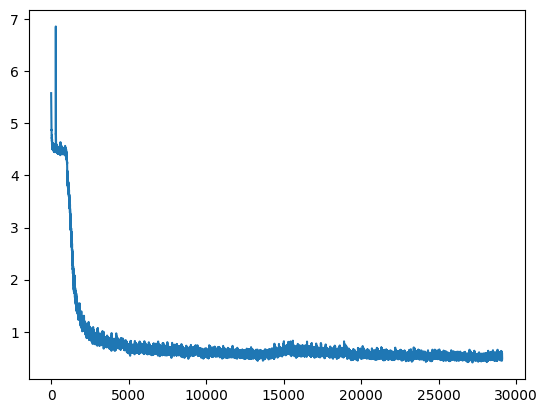

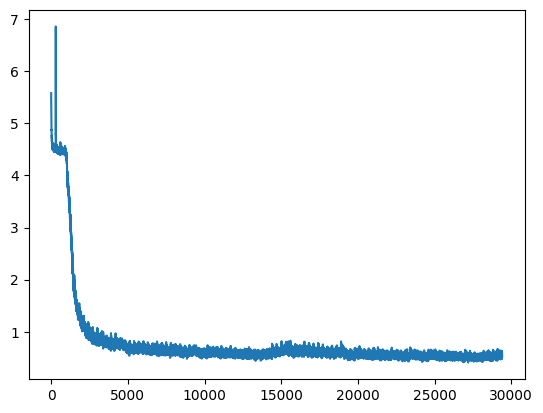

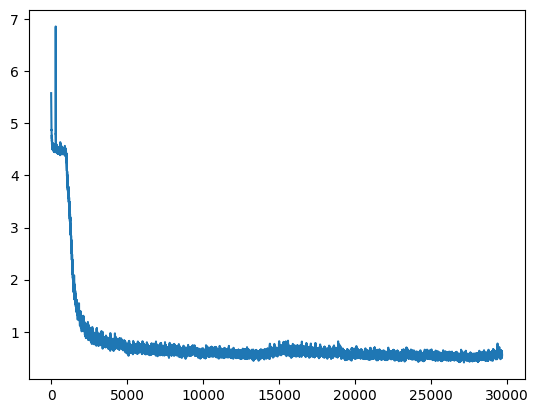

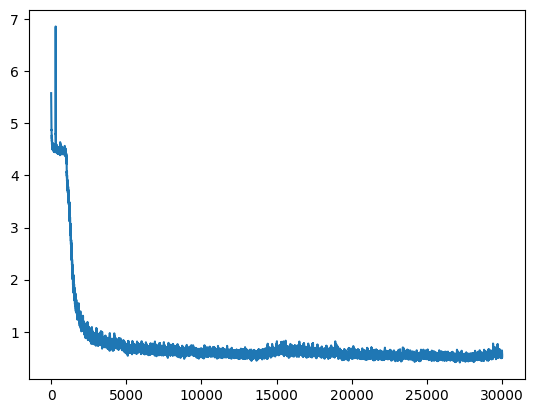

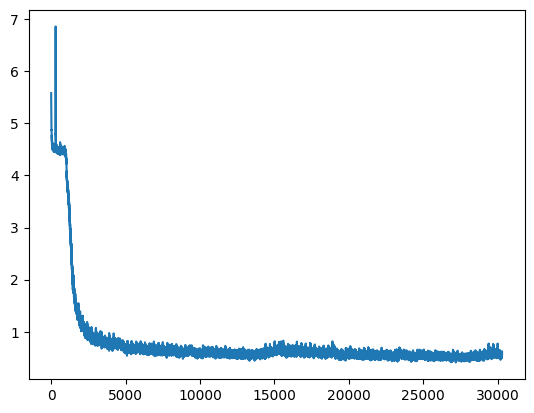

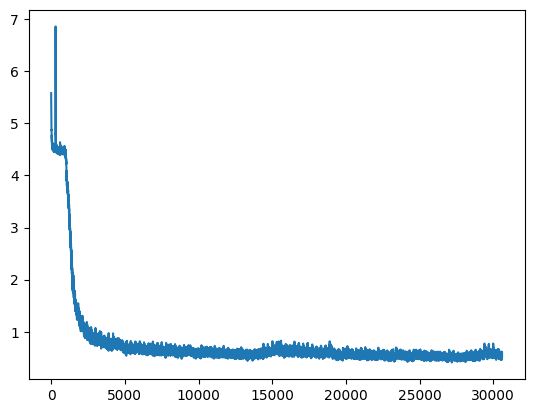

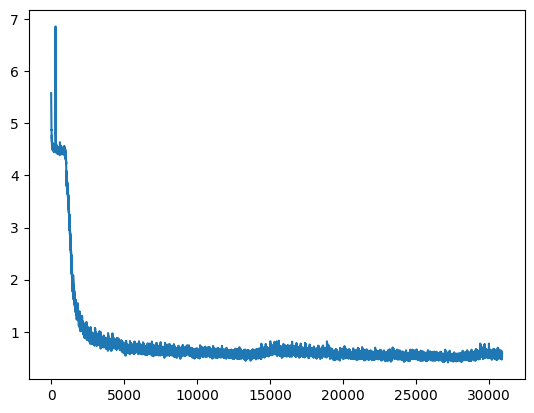

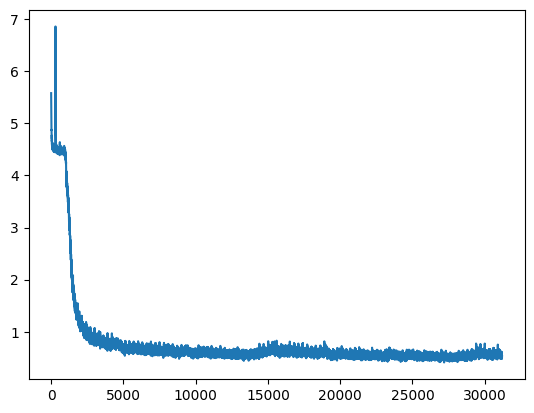

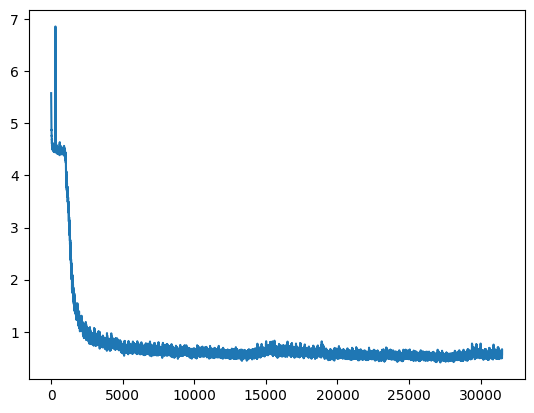

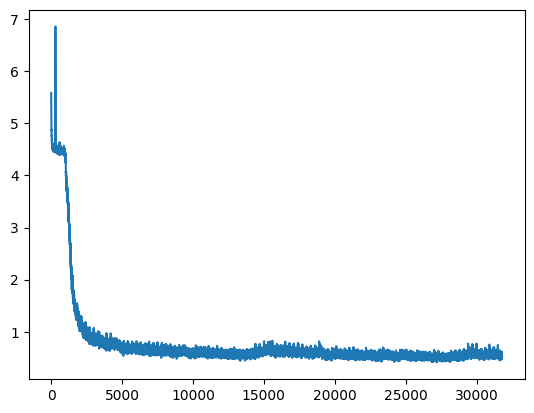

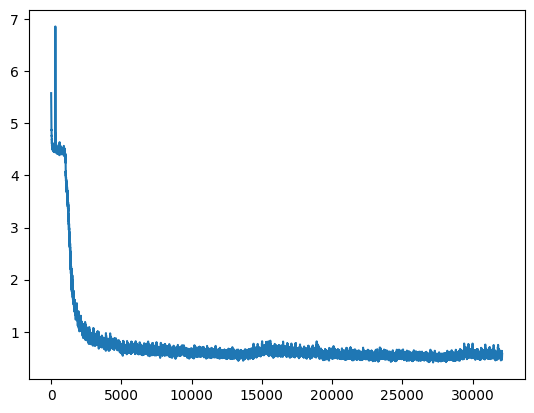

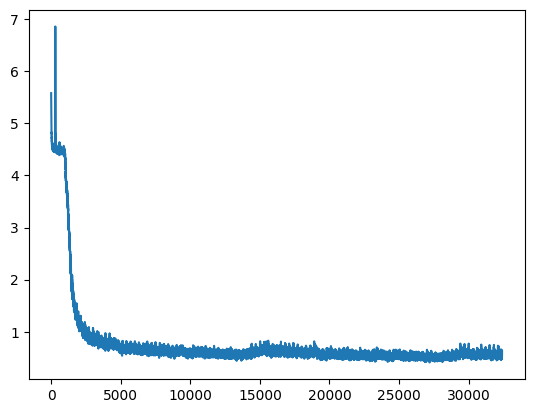

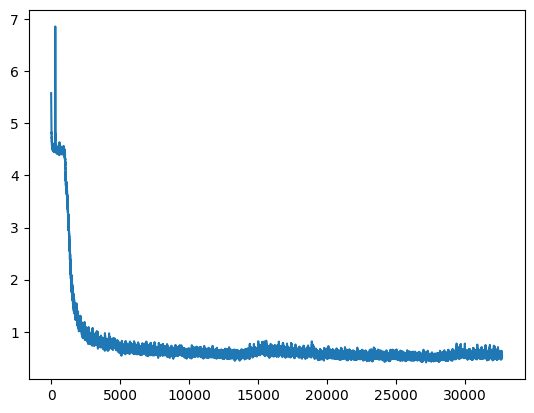

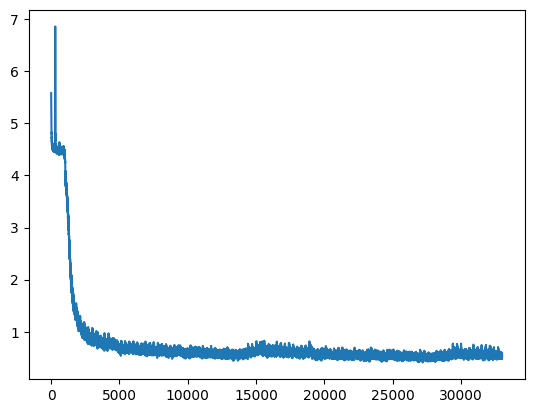

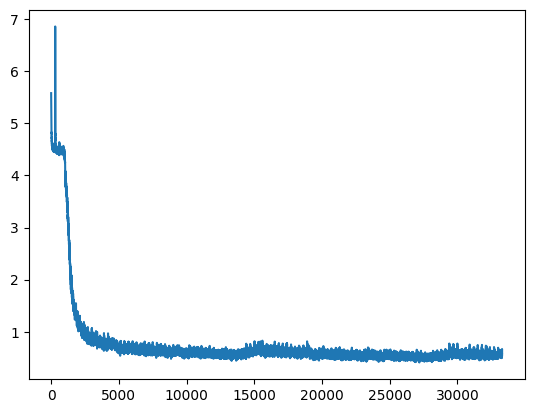

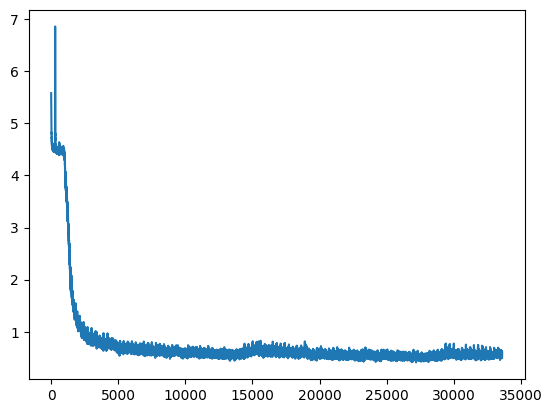

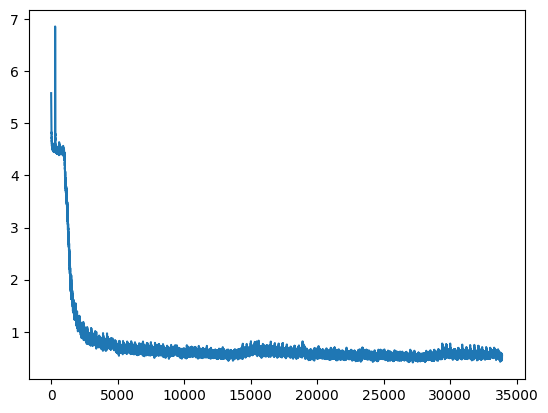

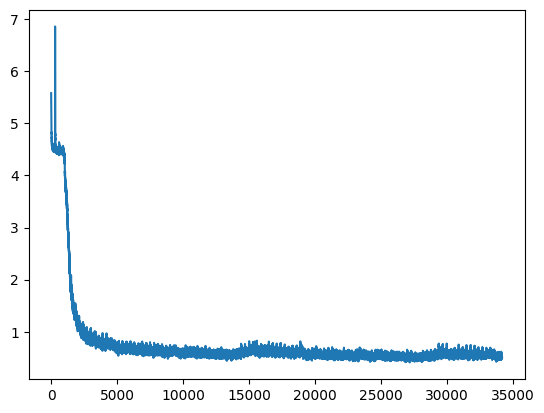

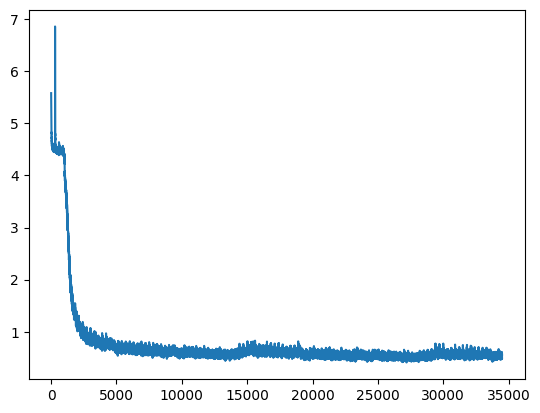

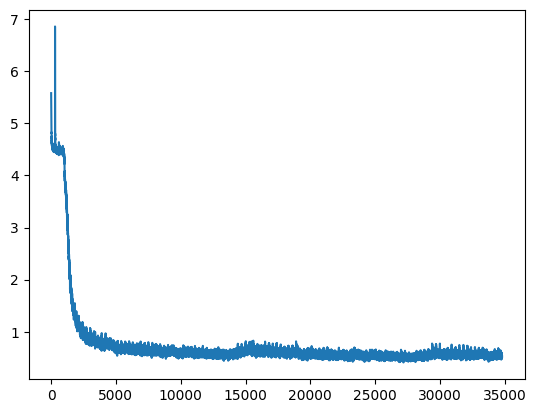

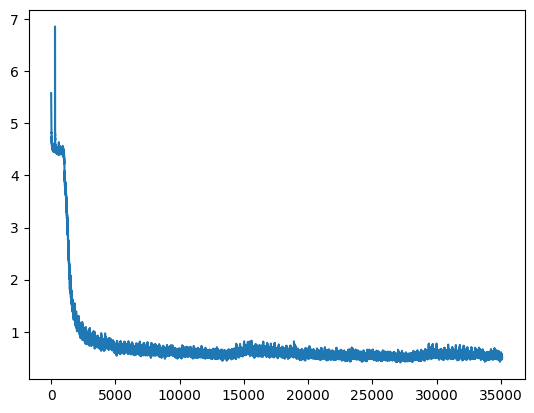

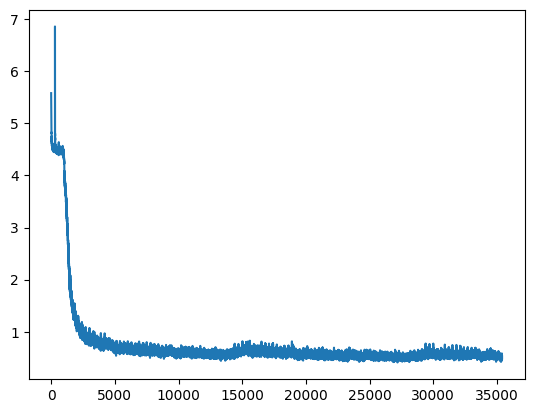

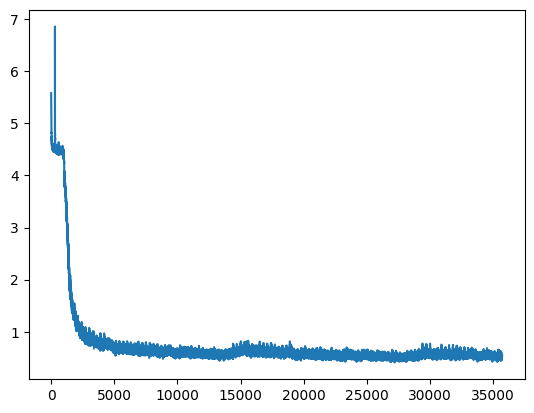

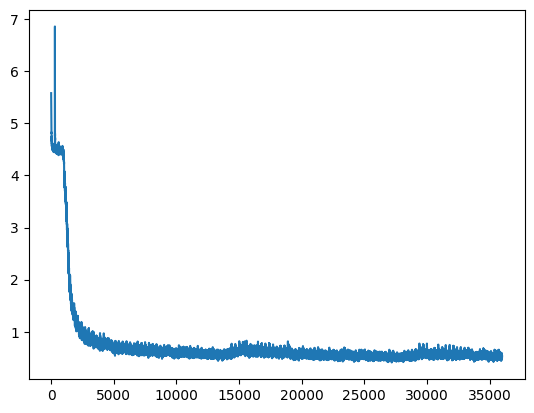

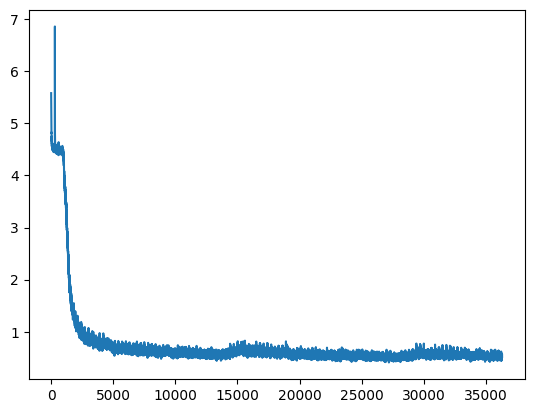

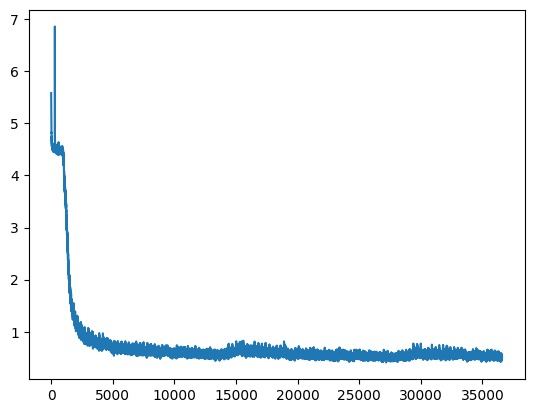

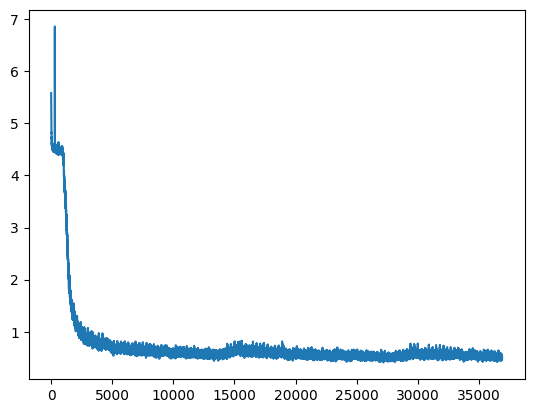

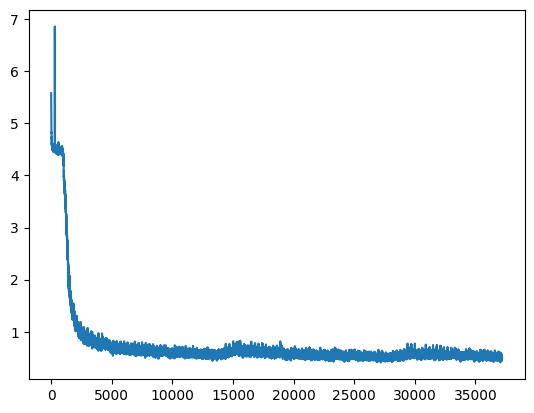

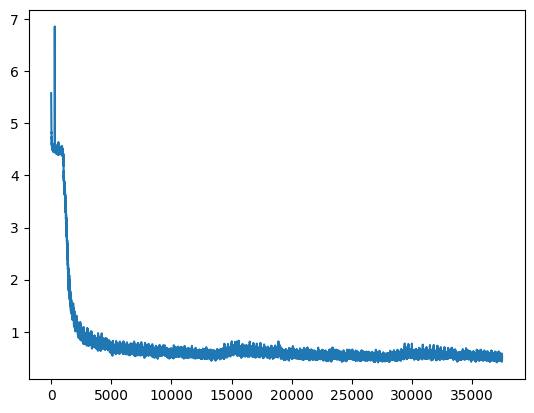

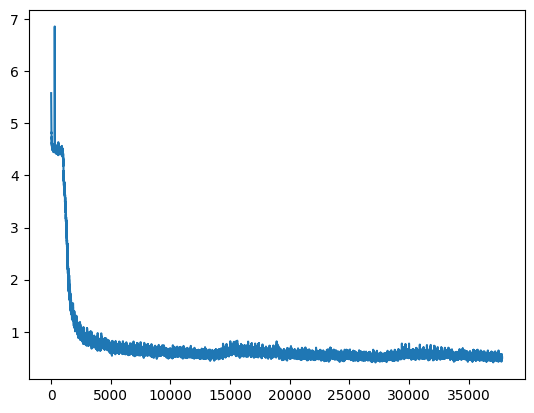

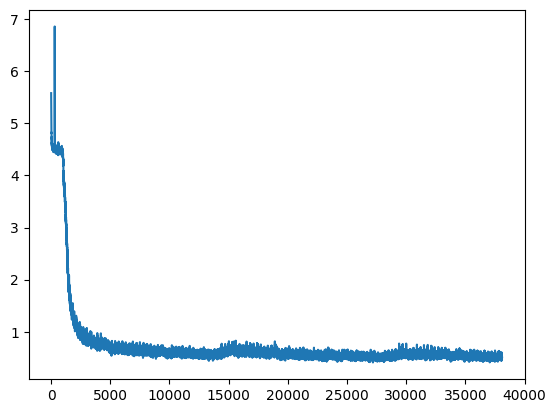

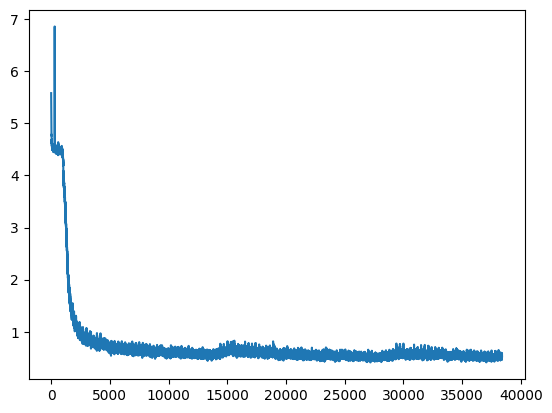

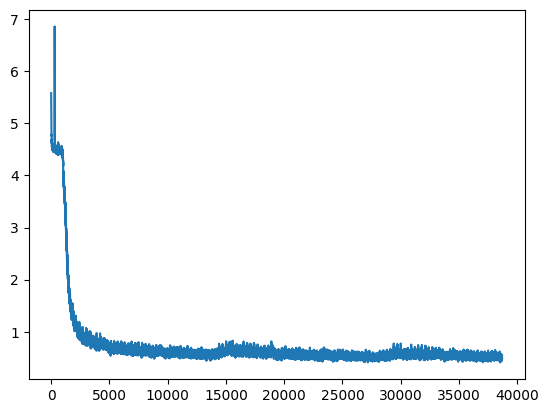

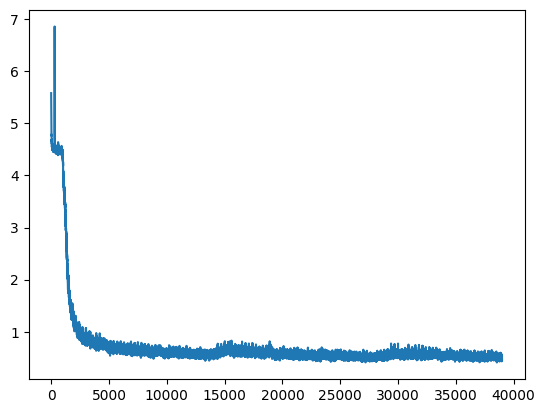

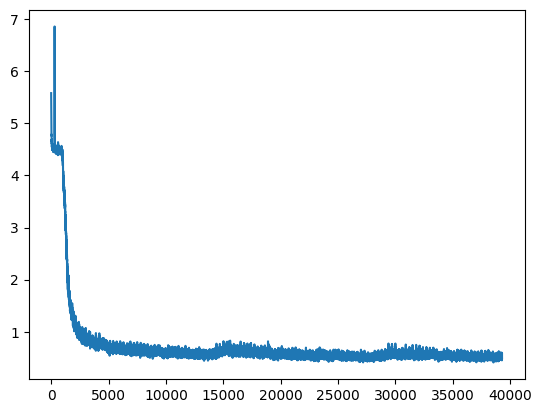

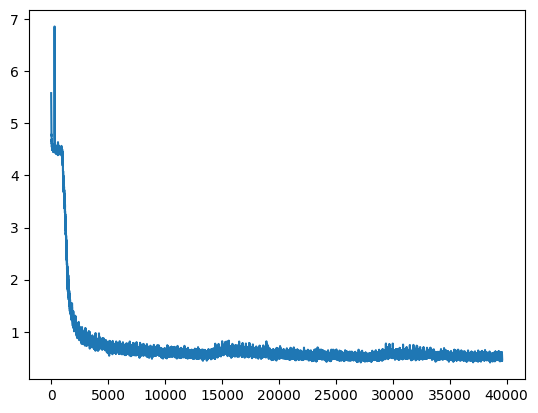

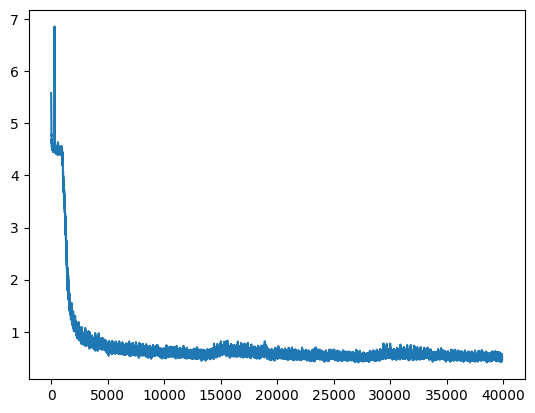

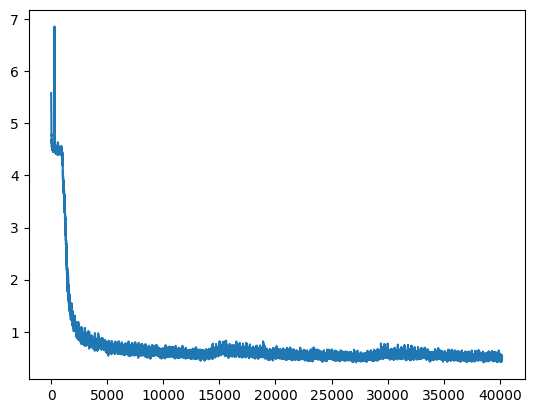

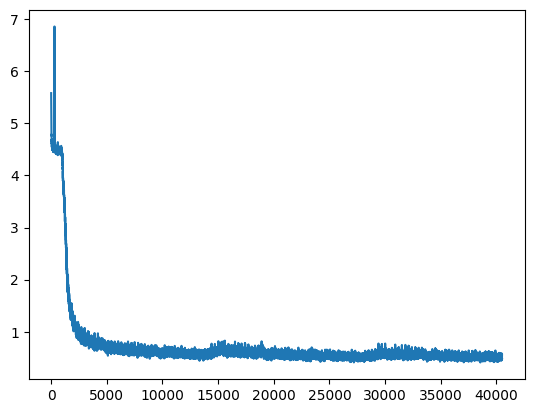

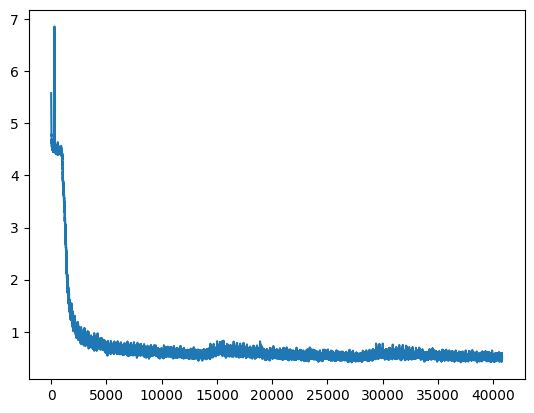

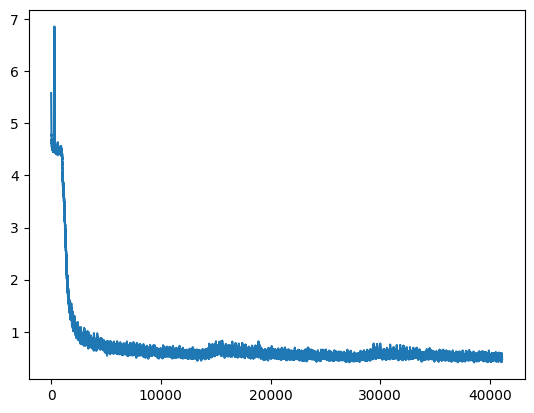

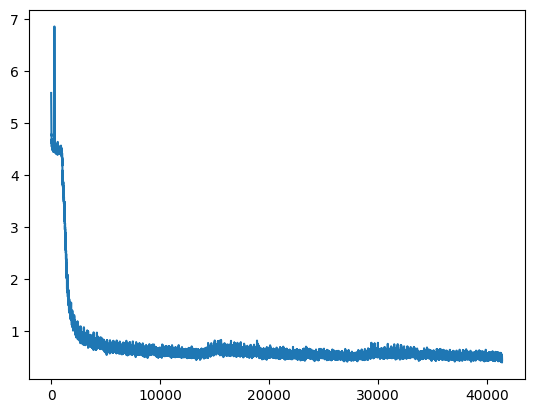

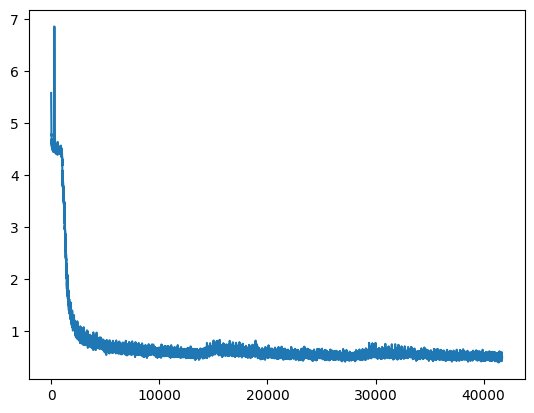

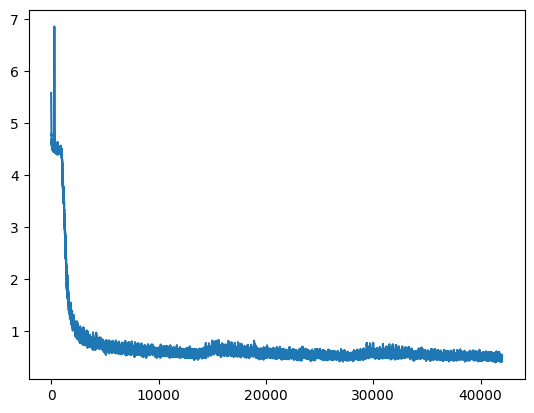

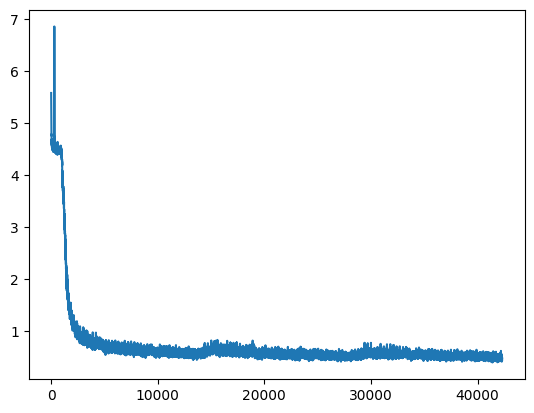

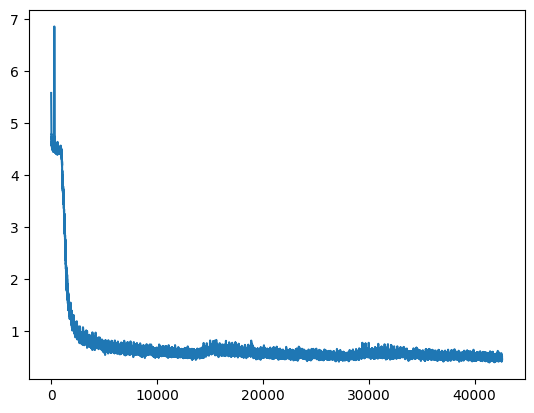

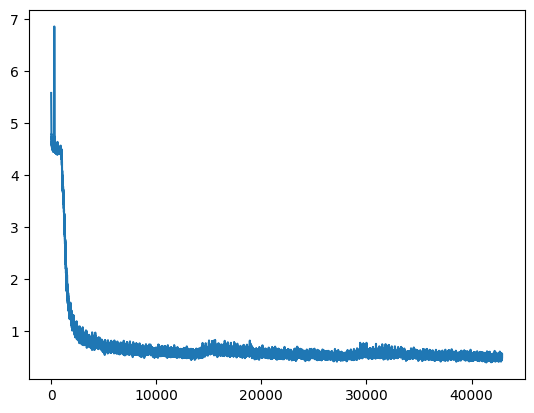

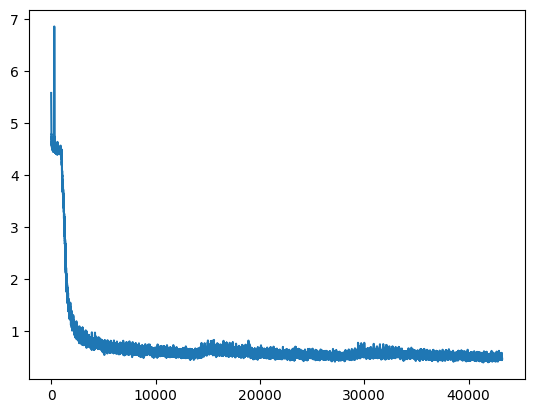

In [6]:
### Train the network on various saved games:    
load_dir = os.path.join(Path.cwd(), 'saved_games', 'v3', 'train')
save_paths = os.listdir(load_dir)

### Training parameters:
is_augment = True
epoch_list = [300, 300, 300]
batch_size_list = [512, 512, 512]
is_include_policy = True
is_plot_losses = False
learning_rate_list = [2e-3, 1e-3, 3e-4]

### Iterate over all data sets:
for _ in range(3):
    for _epoch, _bsize, _lr in zip(epoch_list, batch_size_list, learning_rate_list):
        print(f"\n{_epoch=}, {_bsize=}, {_lr=}\n")
        
        for _path in save_paths:
            print(_path)
            
            data_location = os.path.join(load_dir, _path)
            
            my_trainer.train(data_location=data_location,
                             is_augment=is_augment,
                             epochs=_epoch,
                             batch_size=_bsize,
                             is_include_policy=is_include_policy,
                             is_plot_losses=is_plot_losses,
                             learning_rate=_lr,
                             is_mask_policy=False,
                            )
            
            fig, ax = plt.subplots()
            ax.plot(my_trainer.losses)
    
    ### Save the network after training iterations finish:
    save_string = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
    save_path = os.path.join(Path.cwd(), 'saved_networks', 'v3', save_string + '.pt')
    torch.save(my_network.state_dict(), save_path)

In [ ]:
#okay so our next to do is:
# 1. sort out the data loader perhaps
# 2. discover where it is failing and maybe try and correct for that, decide next steps etc.
# 3. start running actual games with actual exploration, 2 moves from the win for example.
        # and make sure this actually works
# 4. 


_epoch=300, _bsize=512, _lr=0.002

2025_07_08_23_19.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_08_23_42.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_00_05.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_00_27.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_00_50.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_01_13.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_01_35.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_01_58.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_02_21.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_02_44.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_03_06.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_03_29.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025

C:\Users\Danie\AppData\Local\Temp\ipykernel_22804\203114208.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


2025_07_09_01_13.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_01_35.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_01_58.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_02_21.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_02_44.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_03_06.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_03_29.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_03_52.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_08_12.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_08_35.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_09_08_57.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299


_epoch=300, _bsize=512, _lr=0.0003

2025_07_08_23_19.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

202

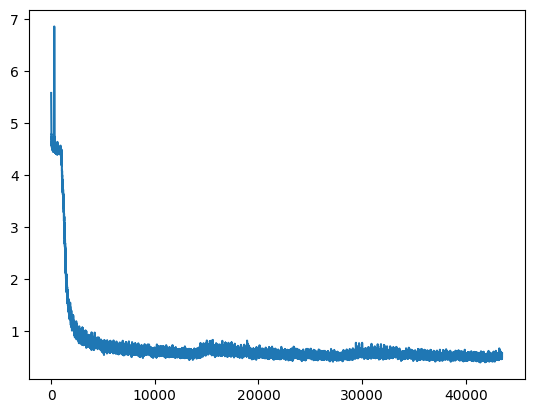

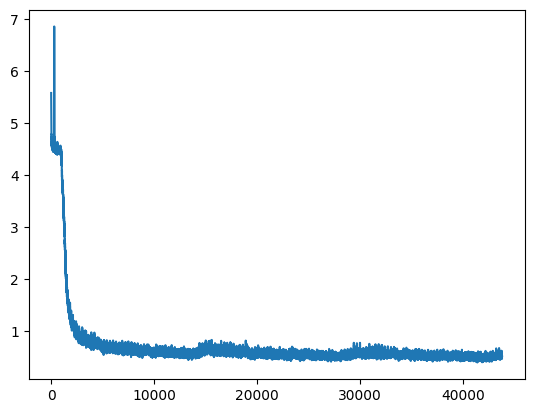

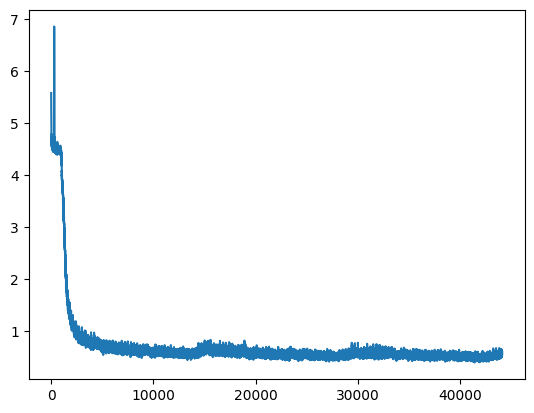

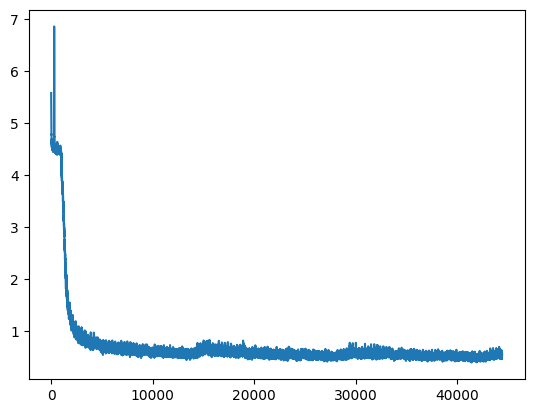

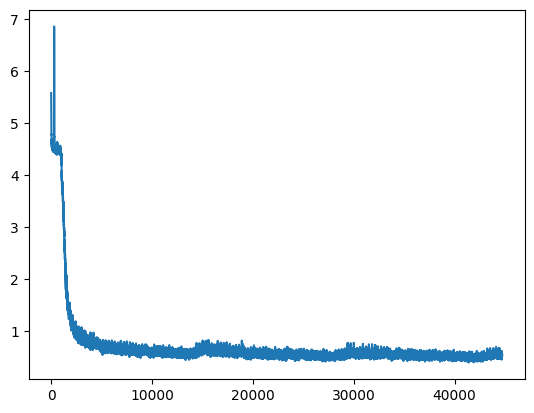

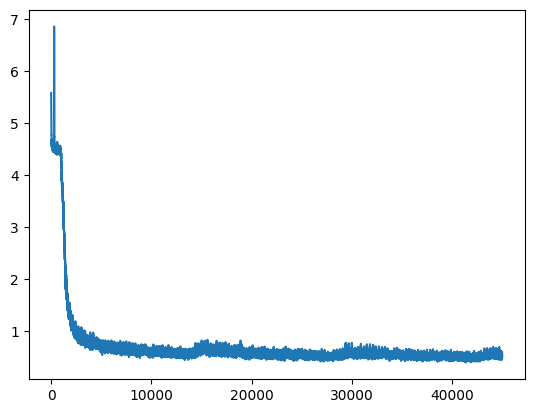

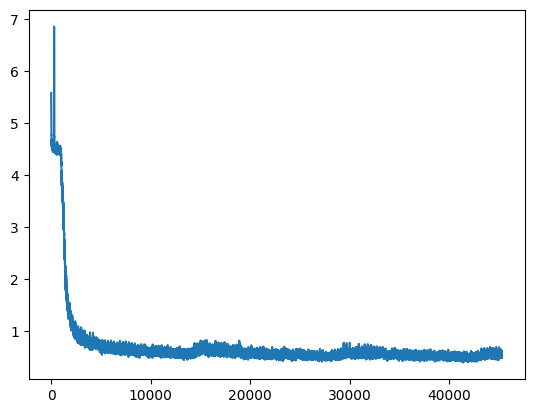

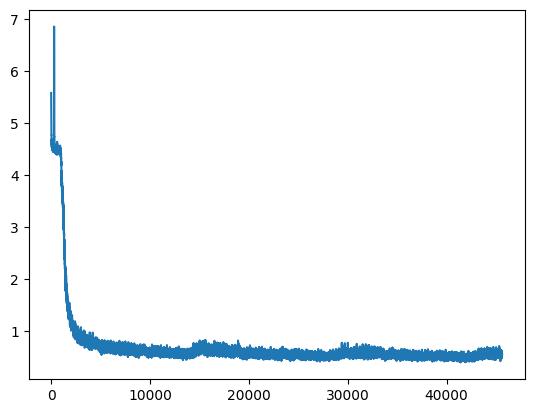

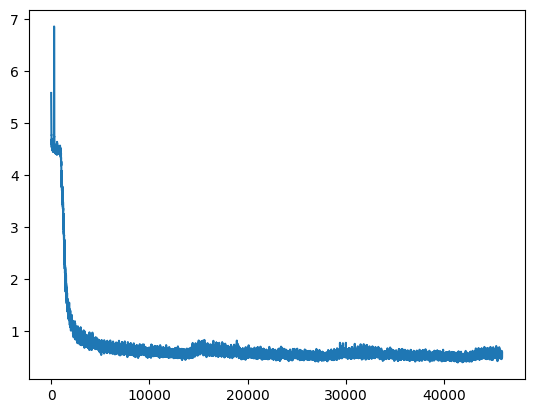

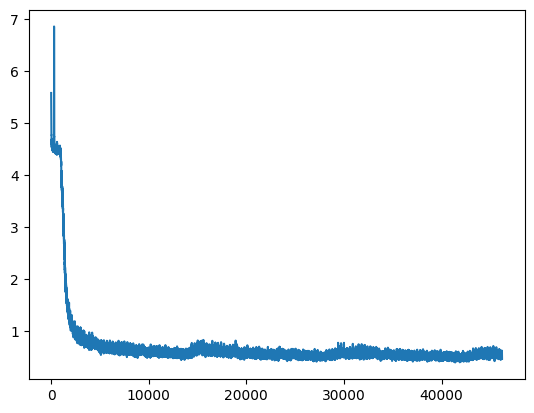

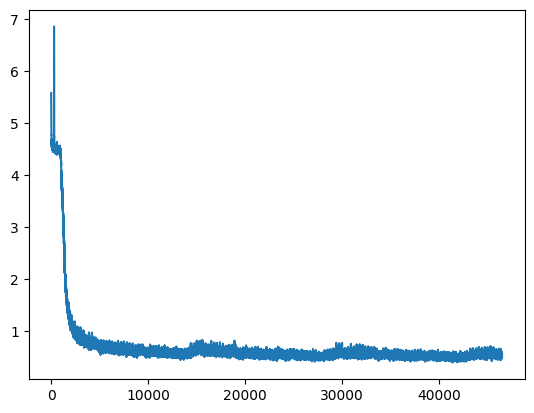

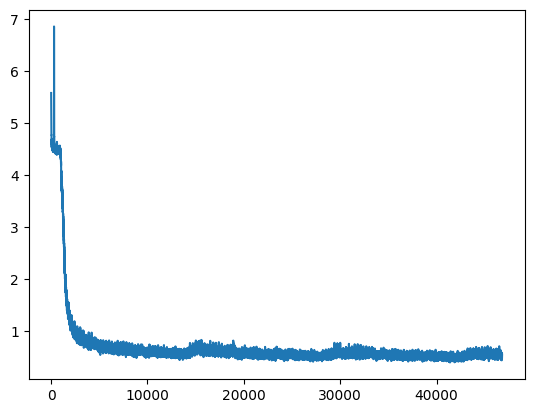

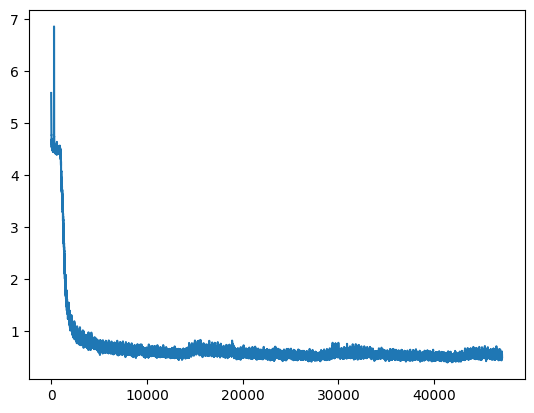

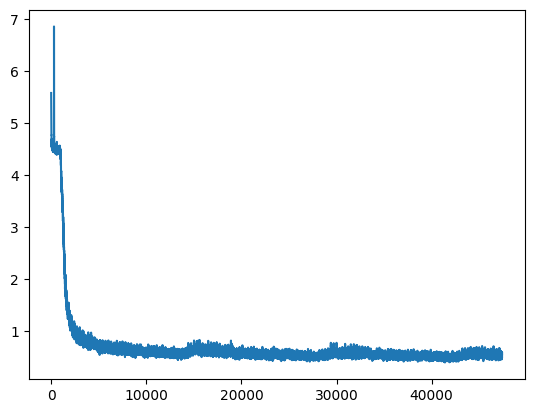

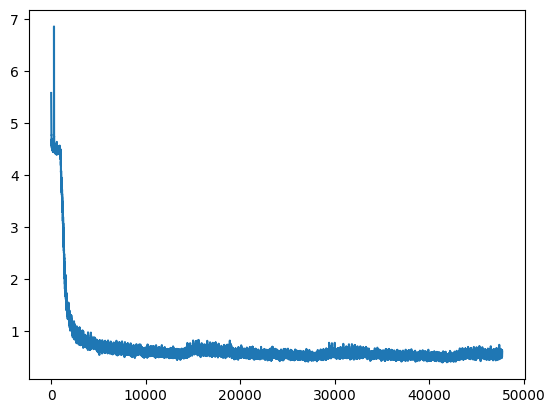

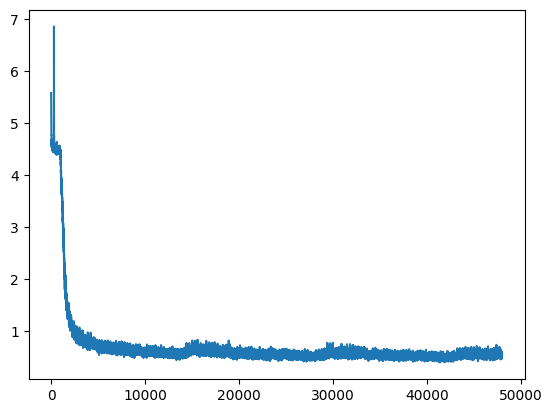

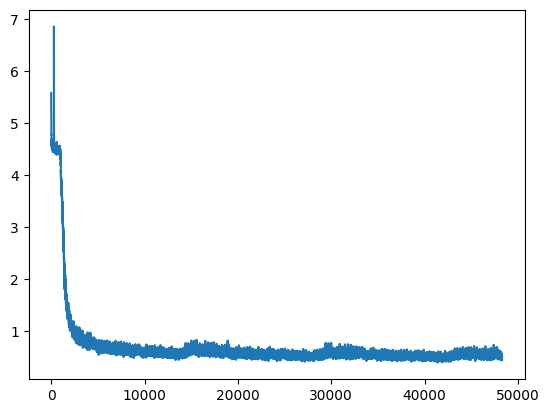

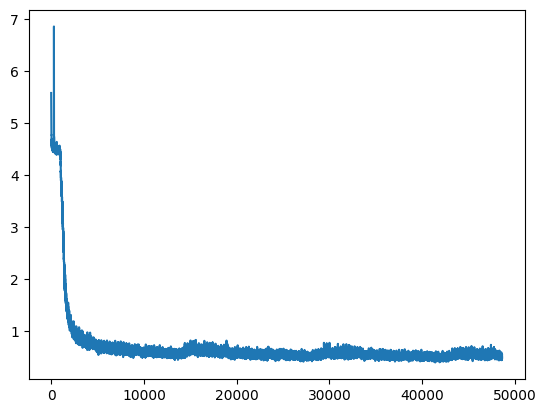

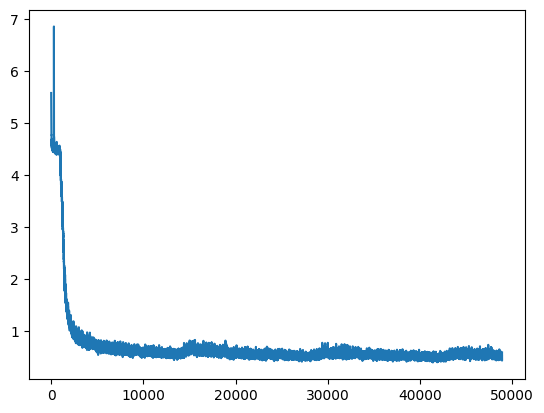

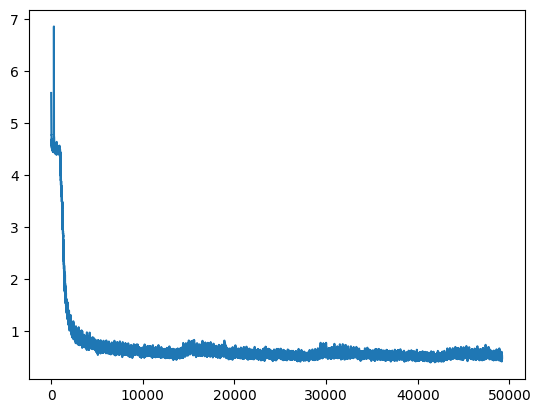

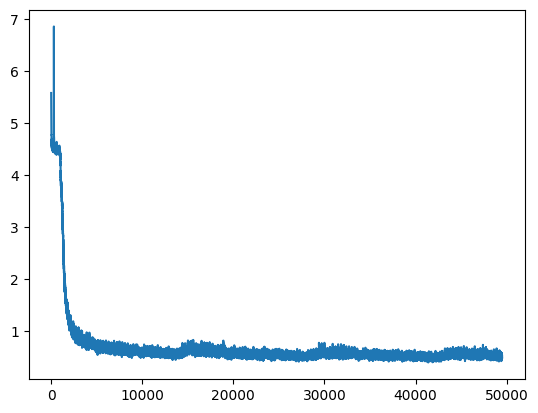

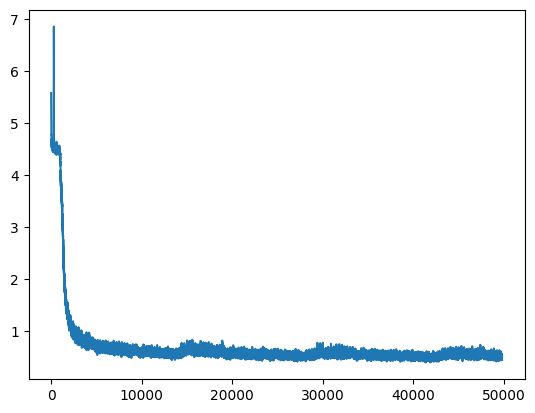

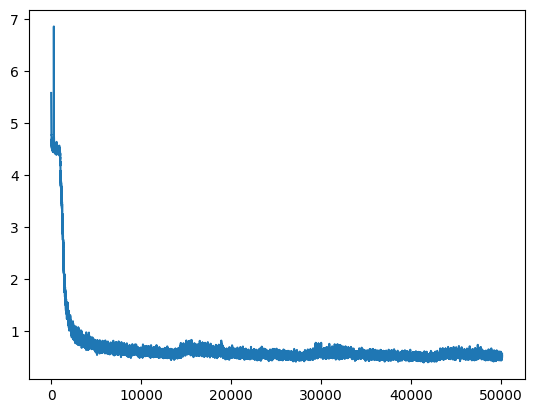

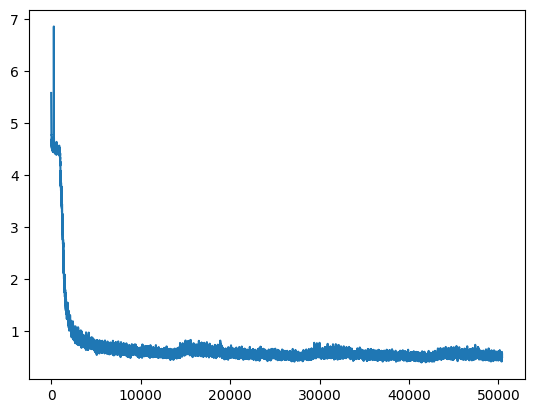

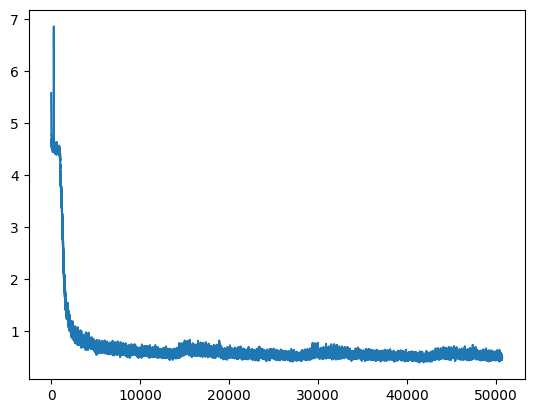

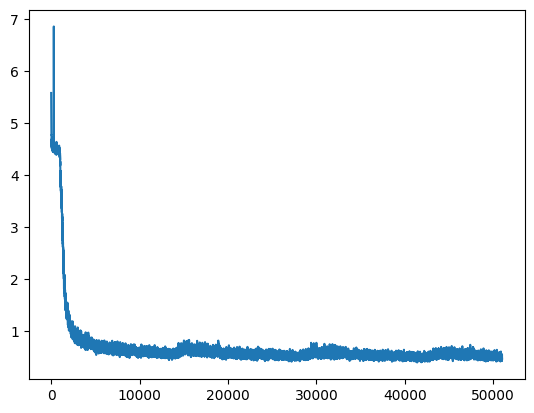

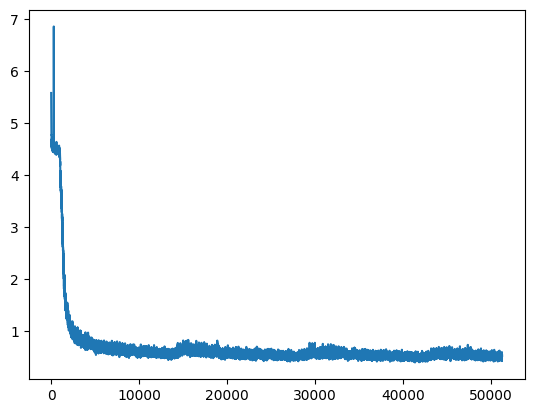

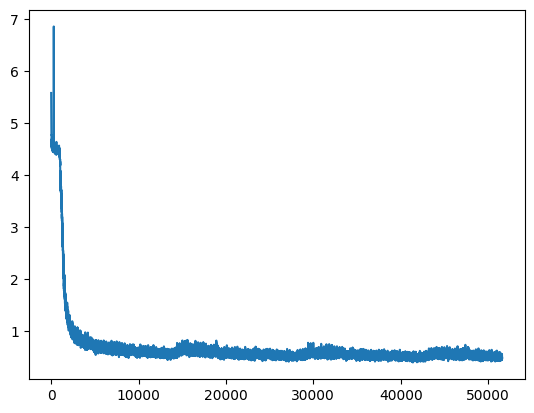

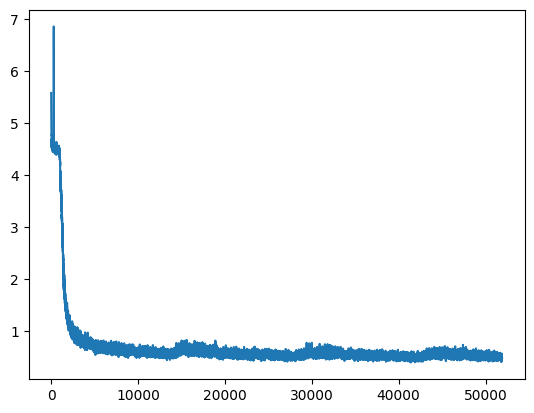

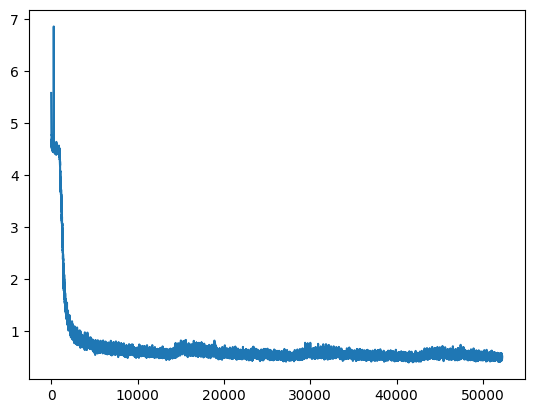

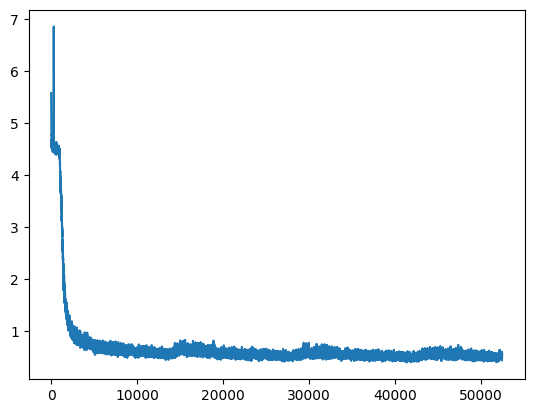

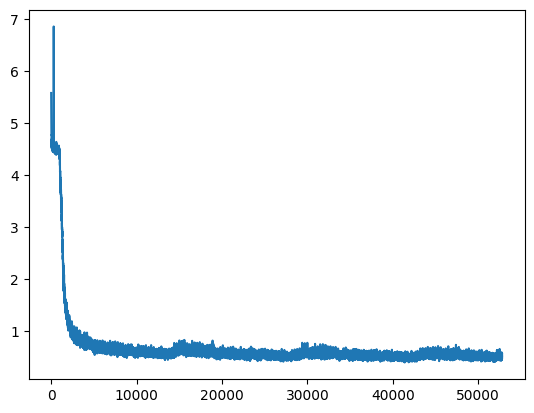

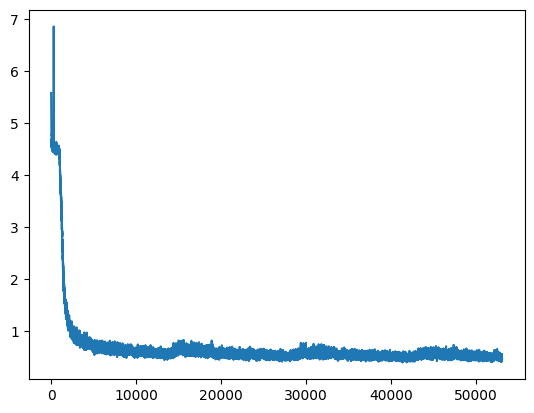

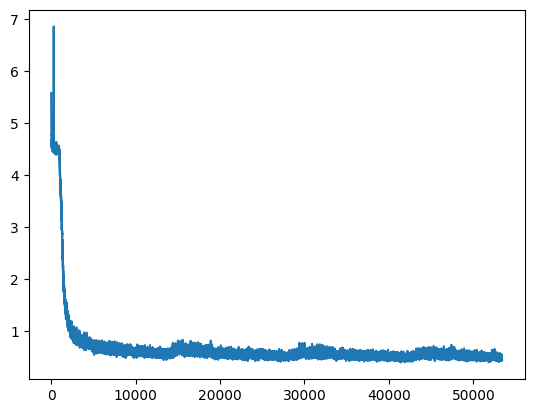

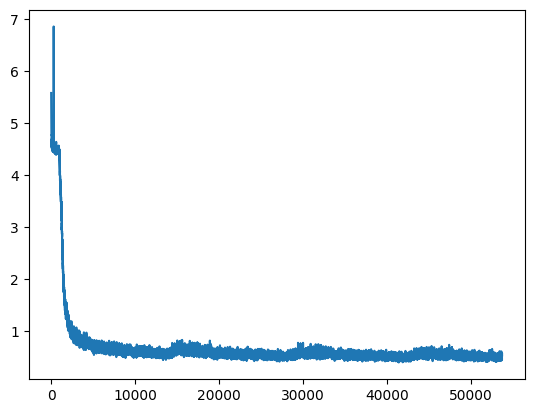

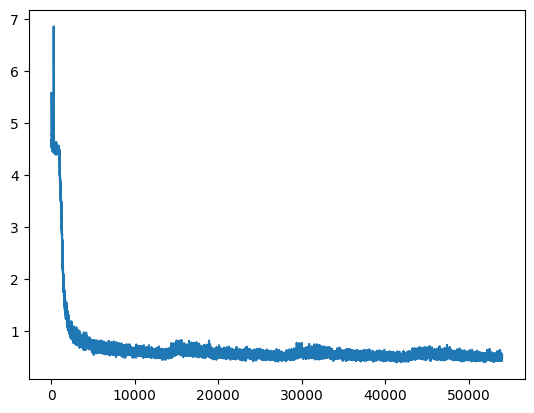

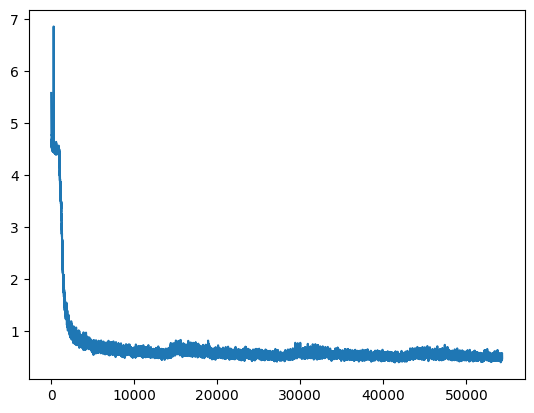

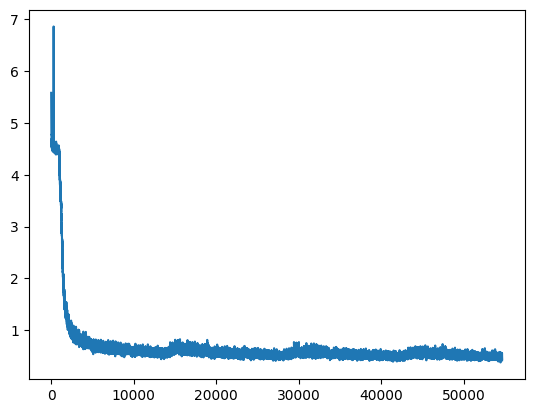

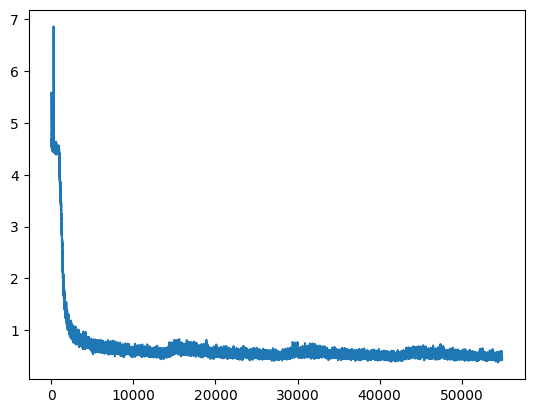

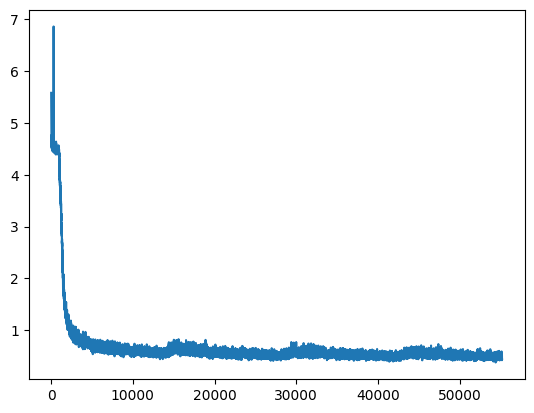

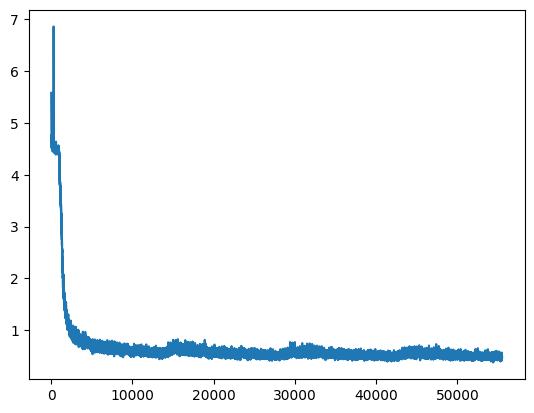

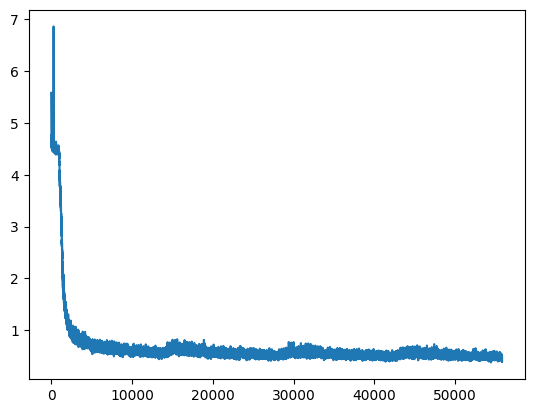

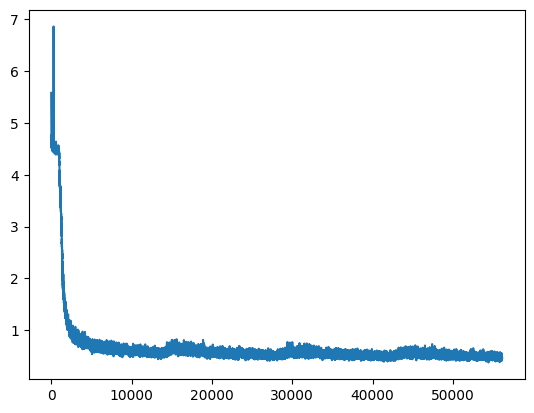

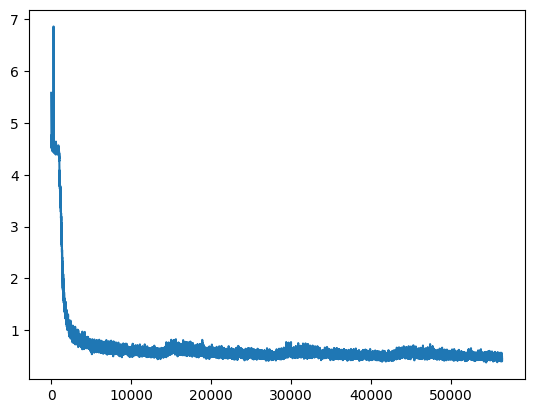

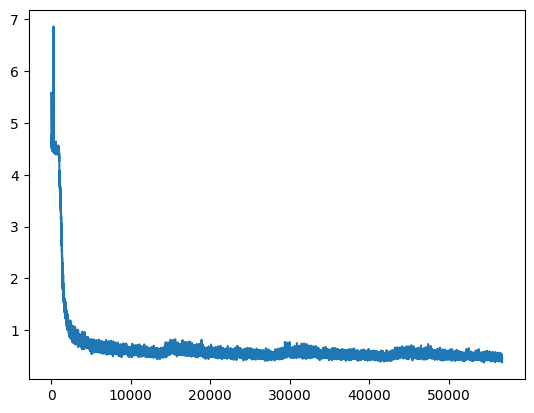

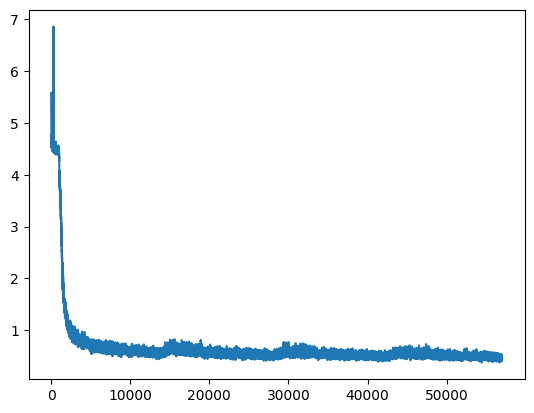

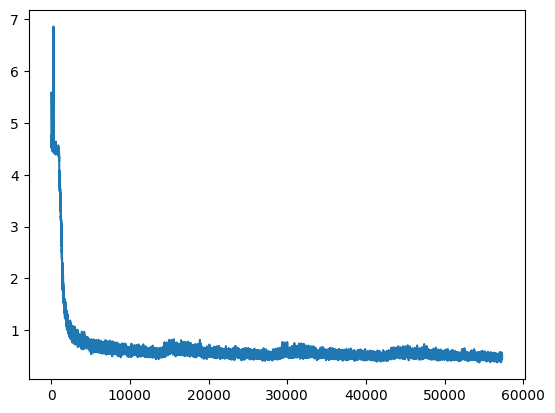

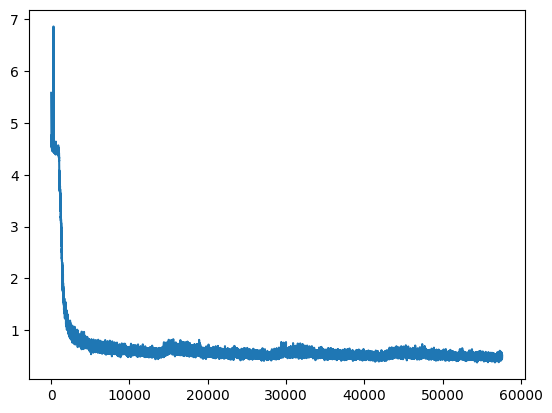

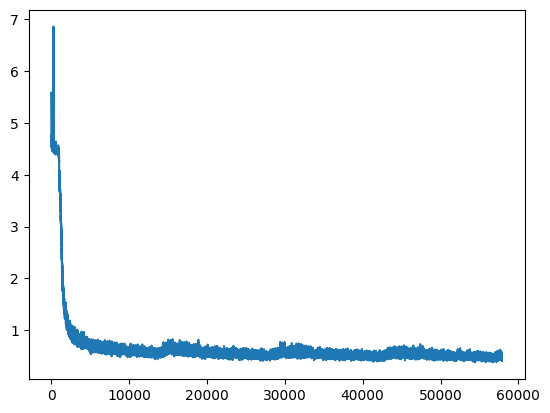

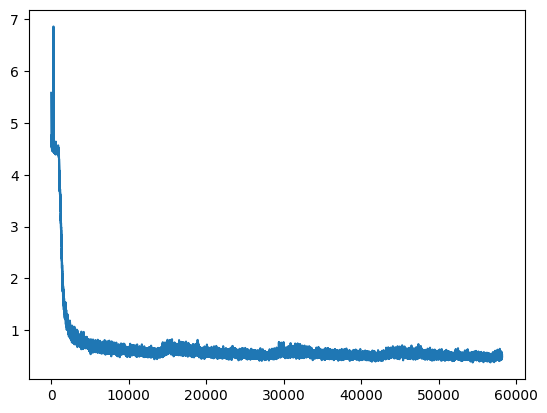

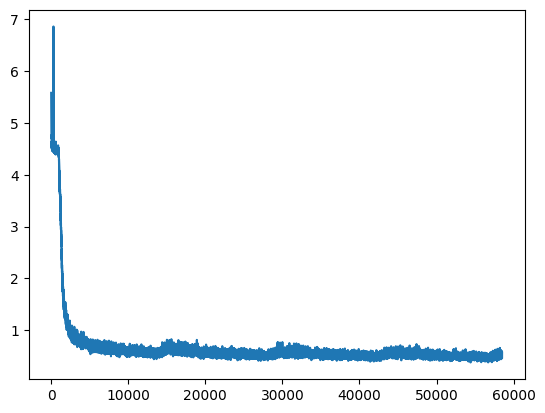

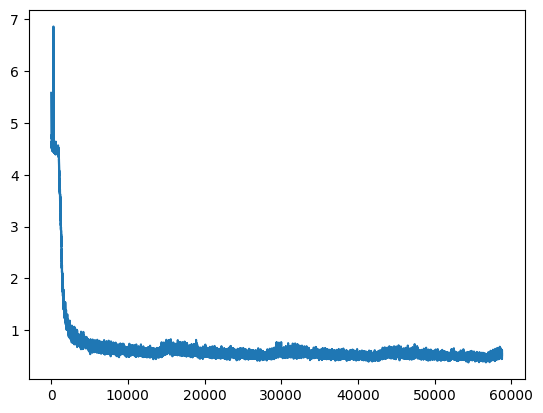

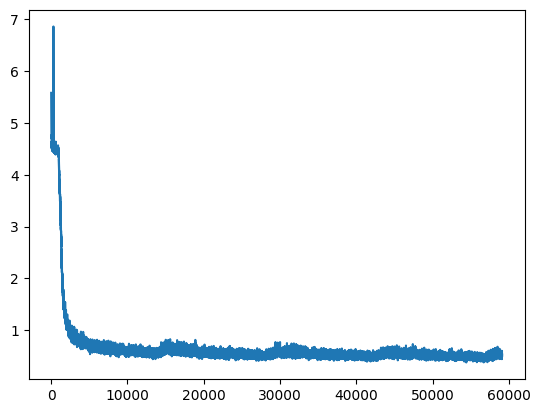

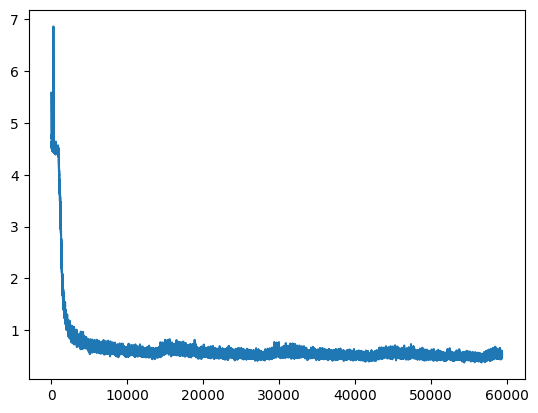

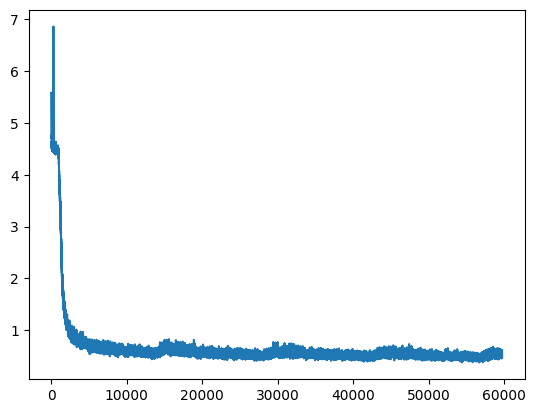

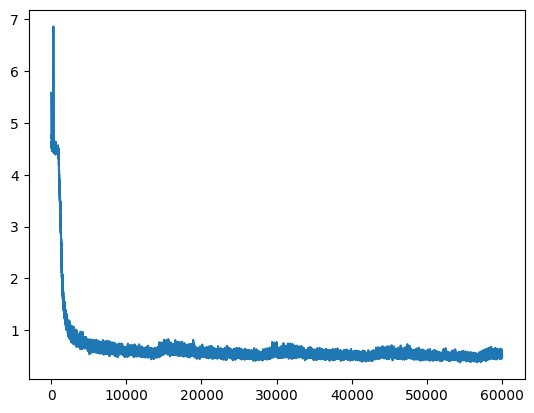

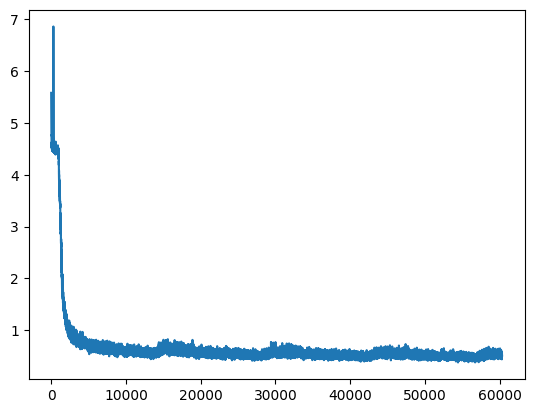

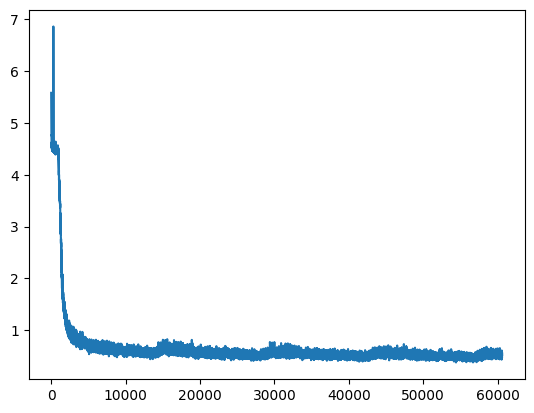

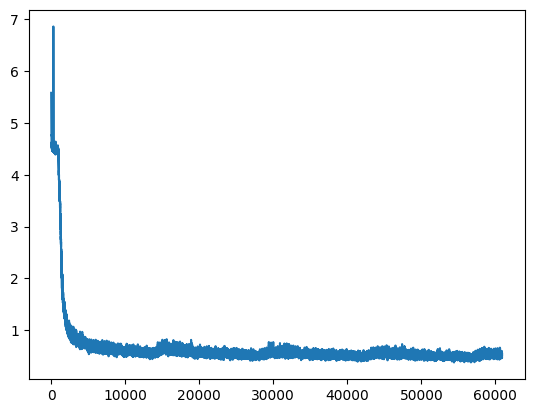

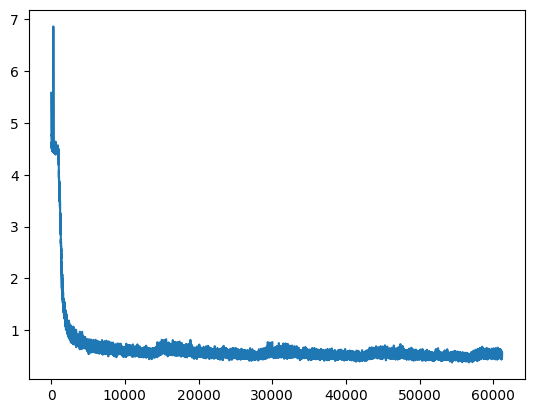

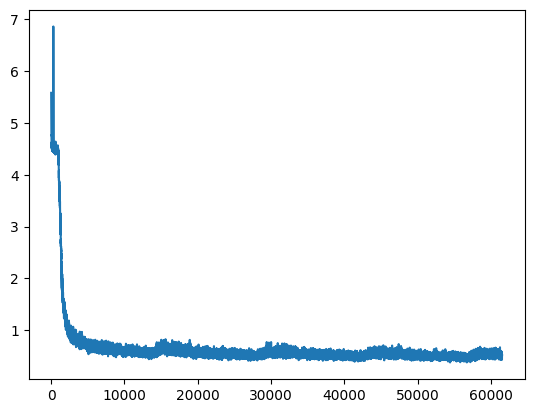

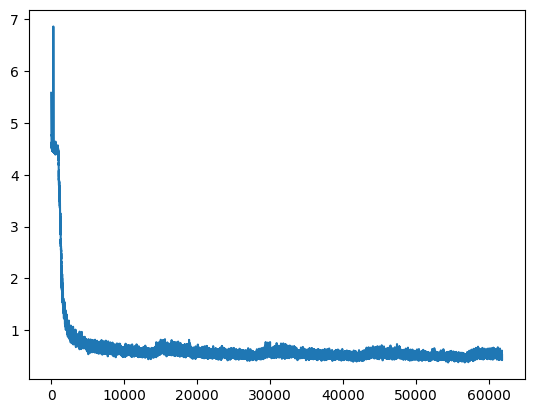

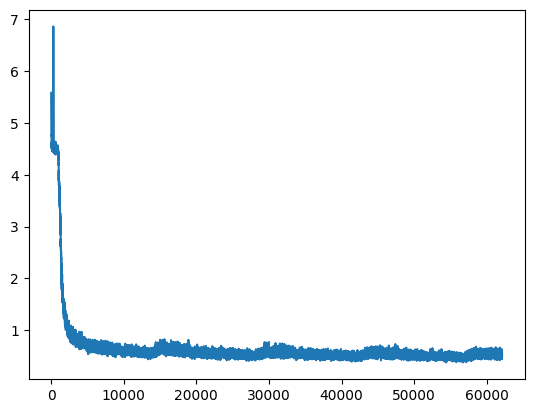

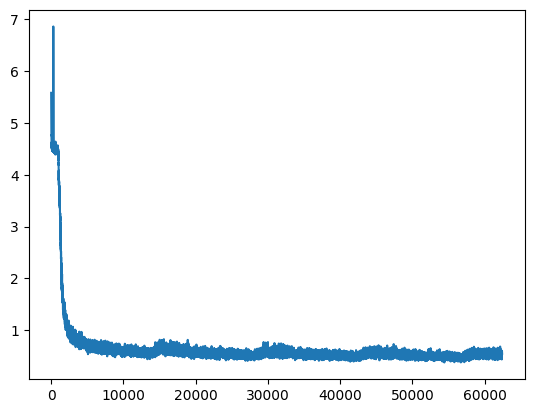

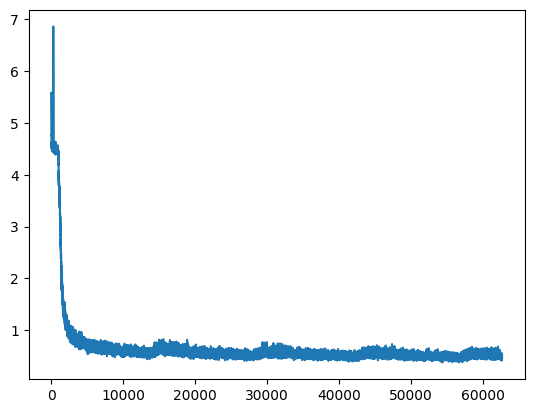

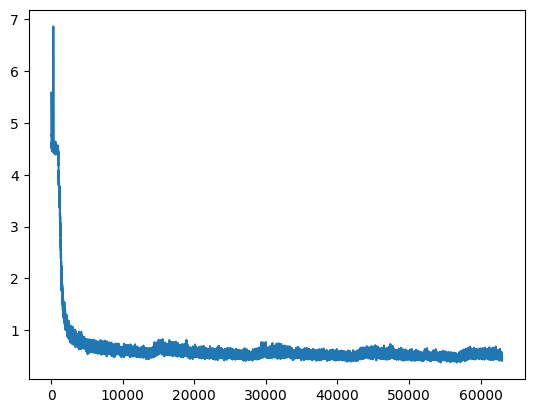

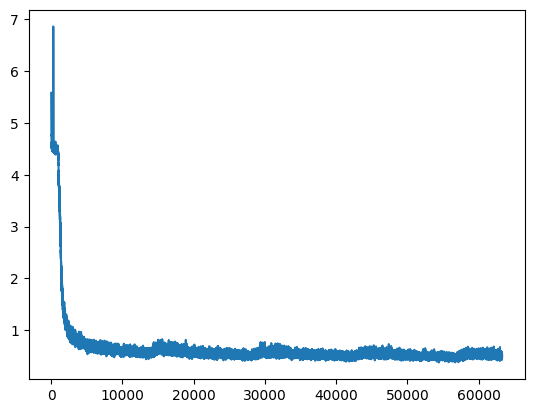

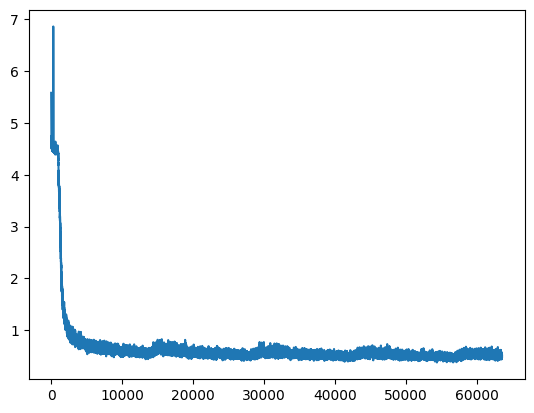

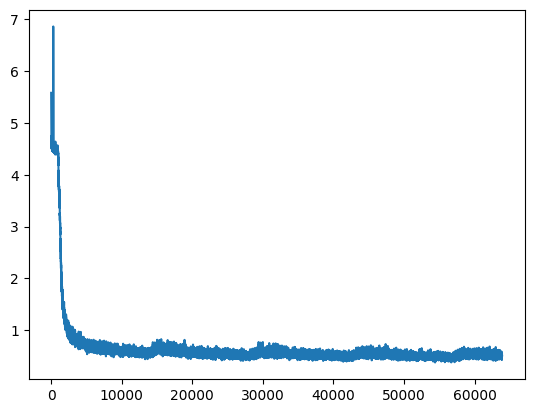

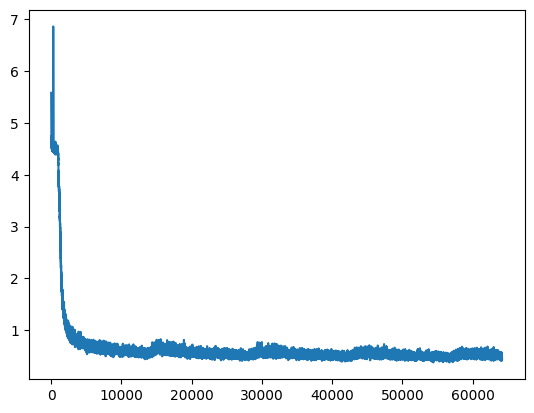

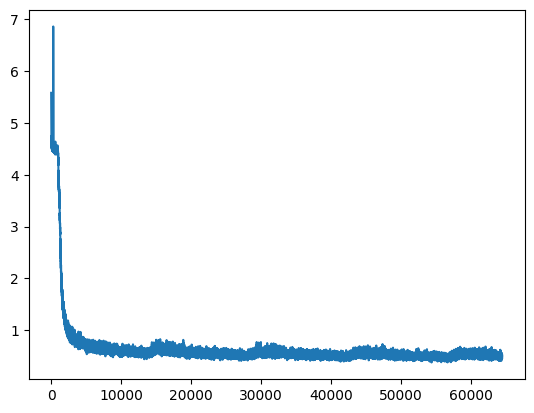

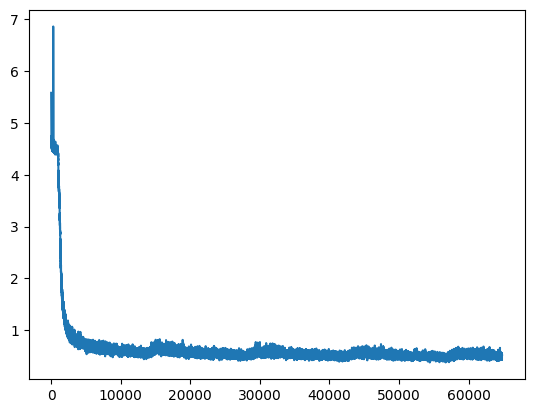

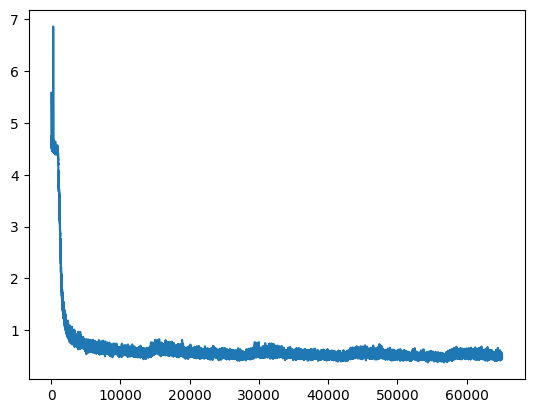

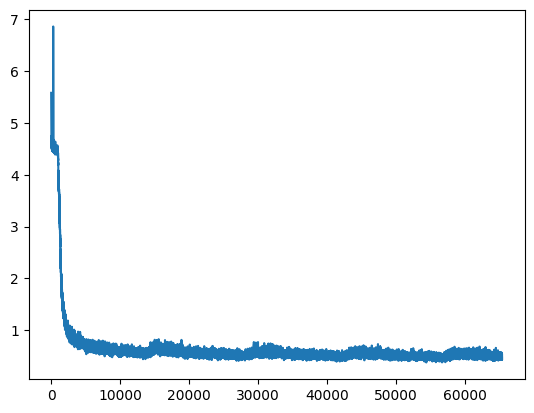

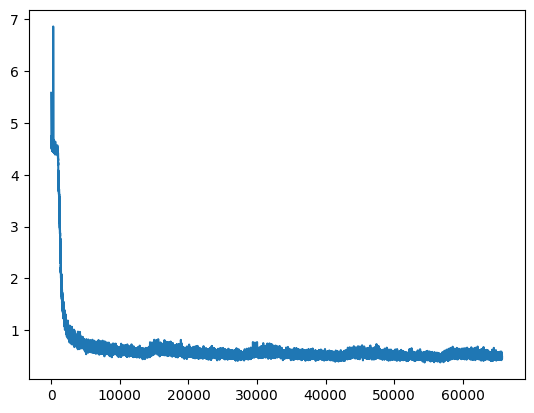

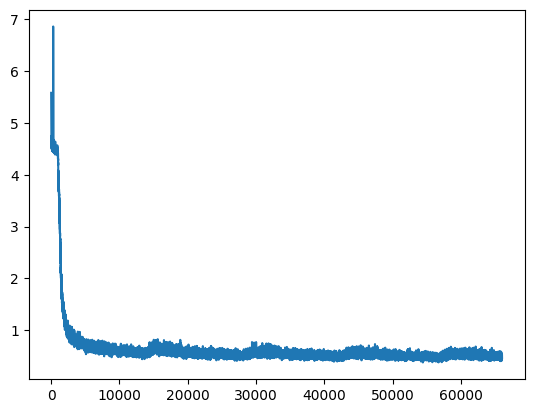

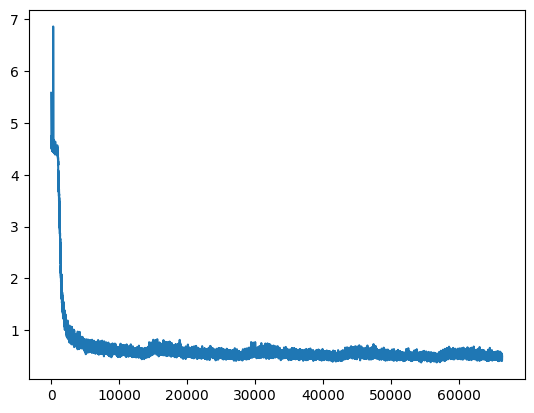

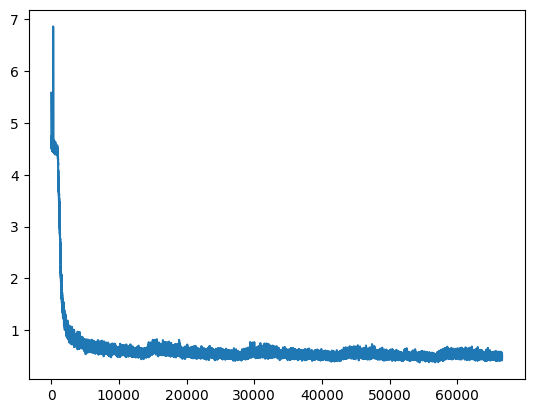

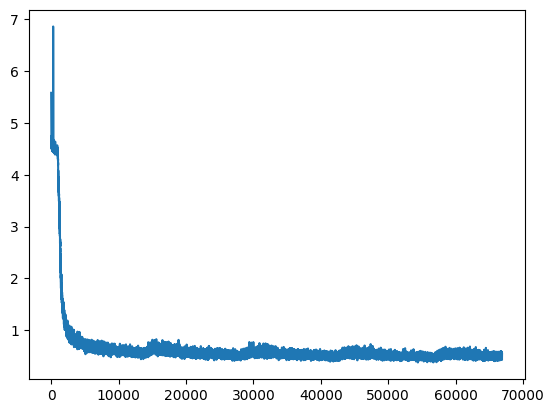

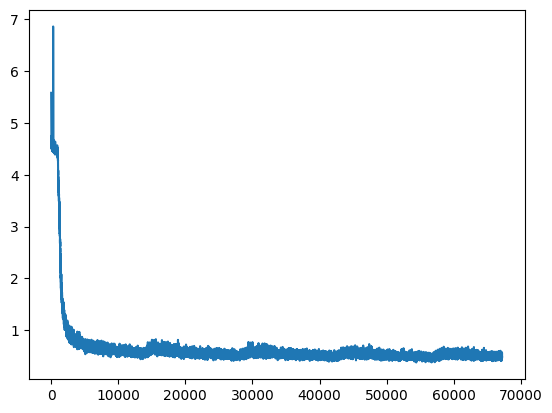

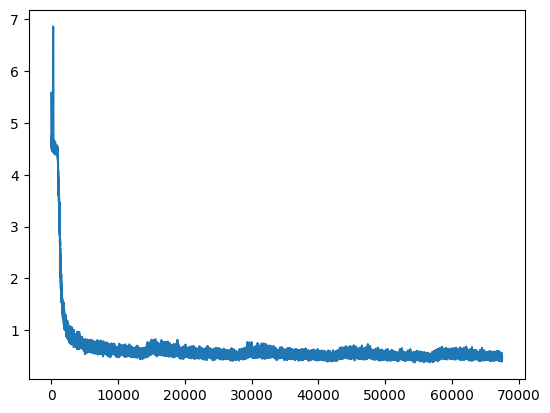

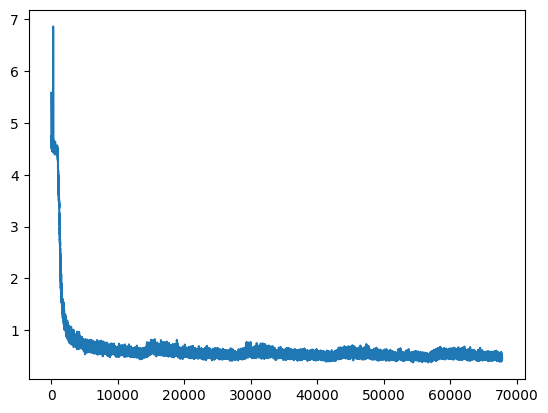

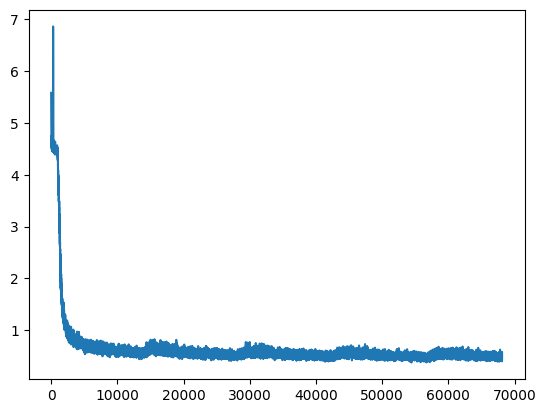

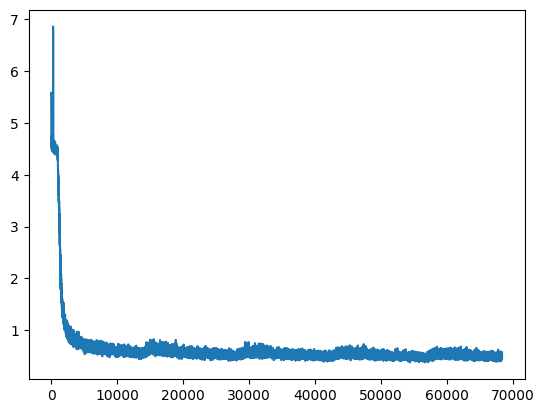

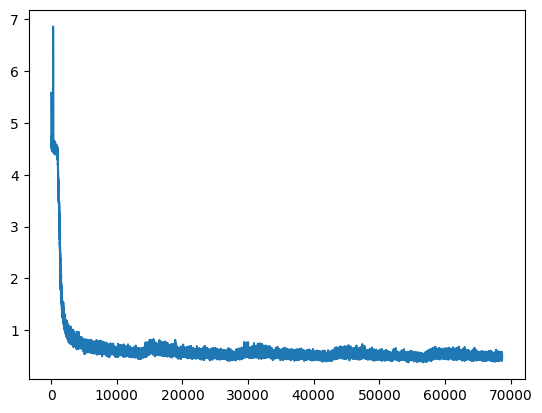

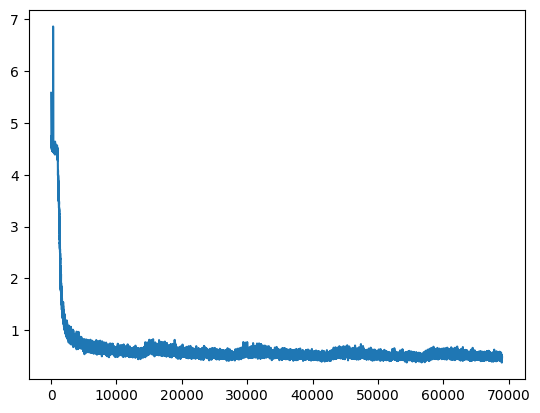

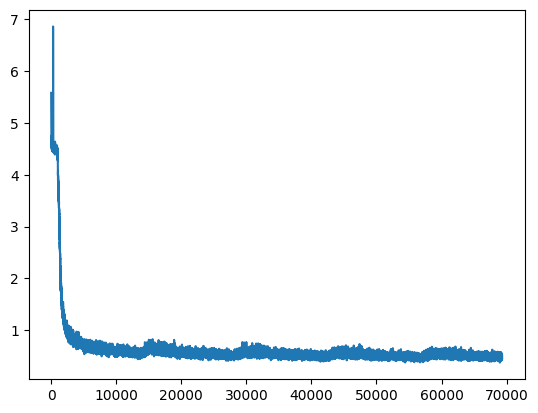

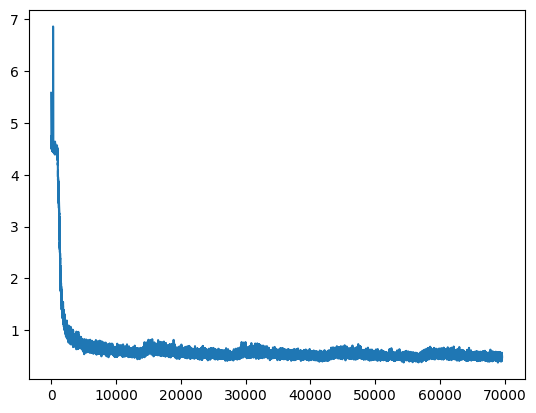

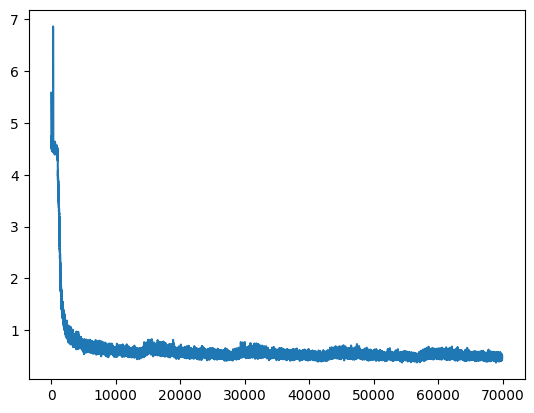

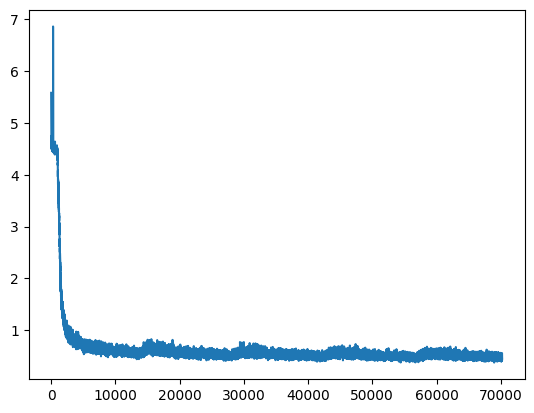

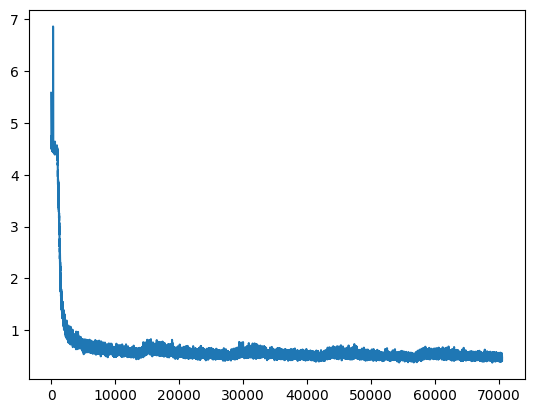

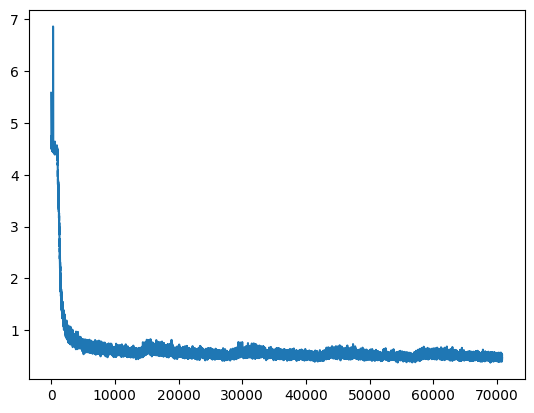

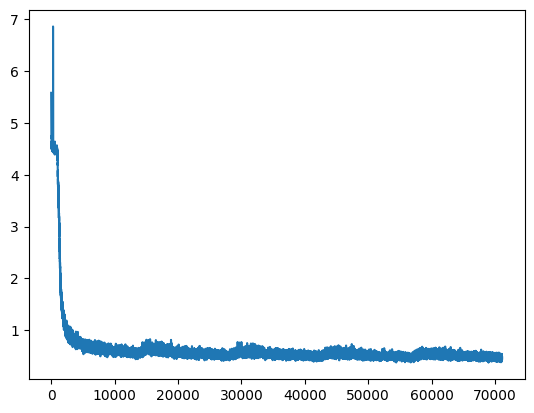

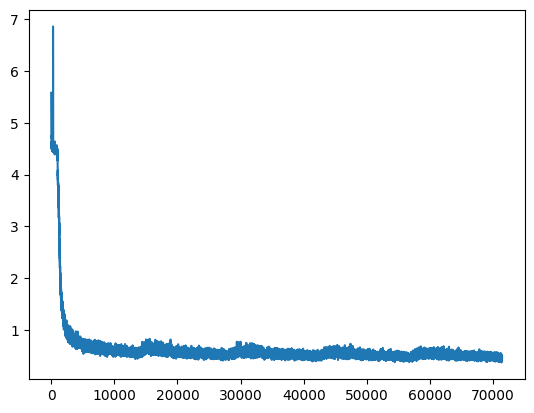

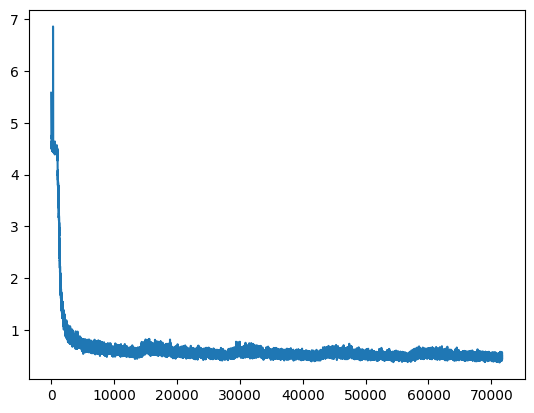

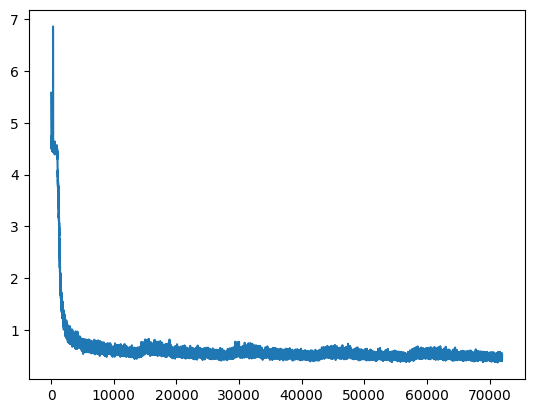

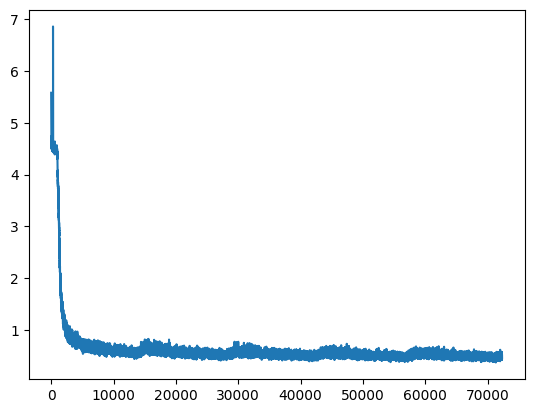

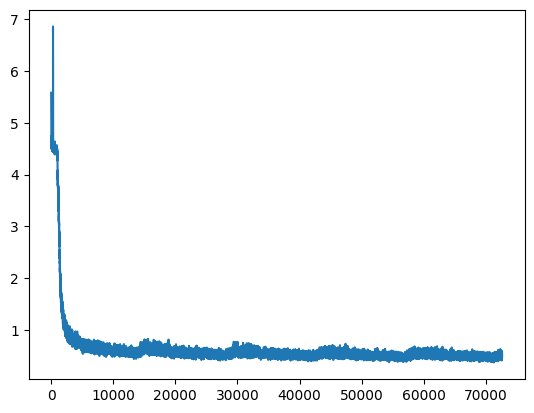

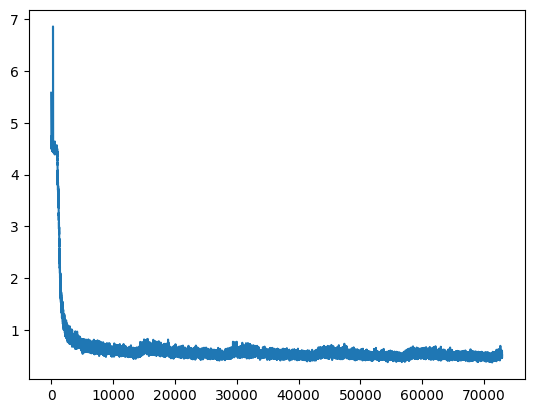

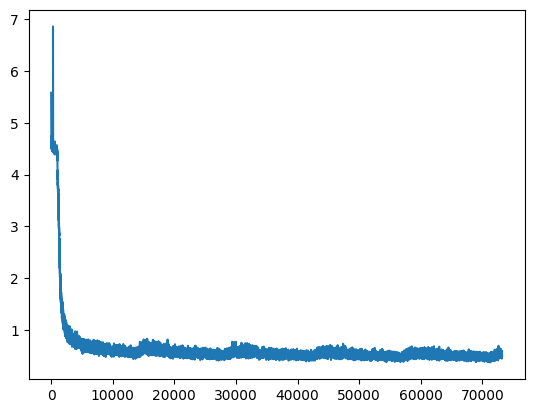

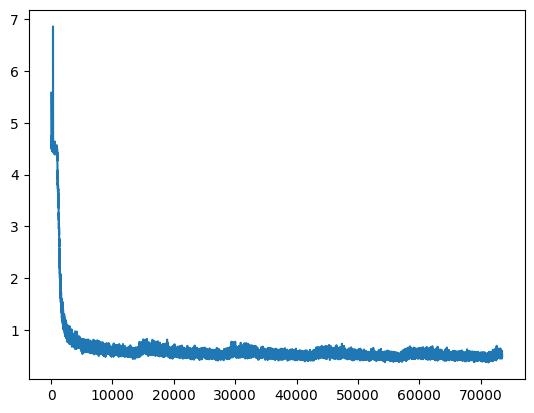

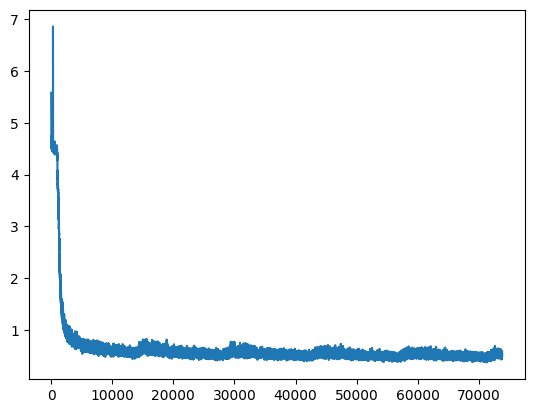

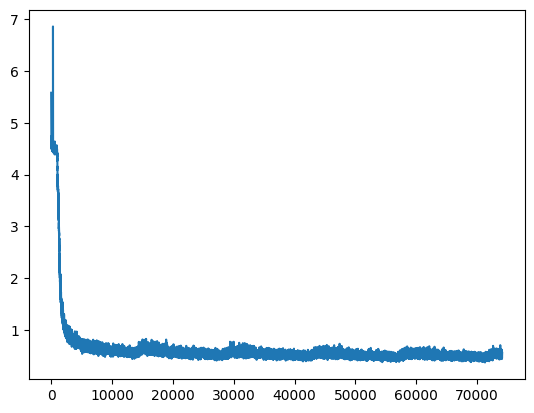

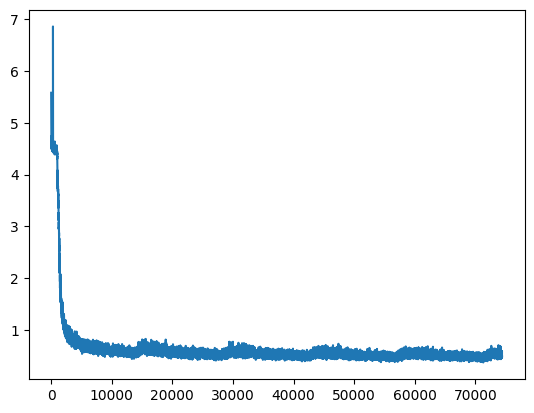

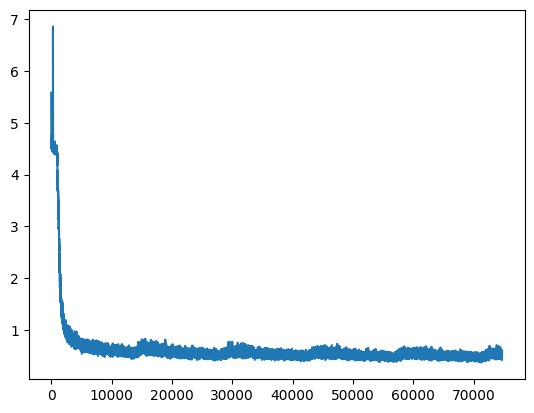

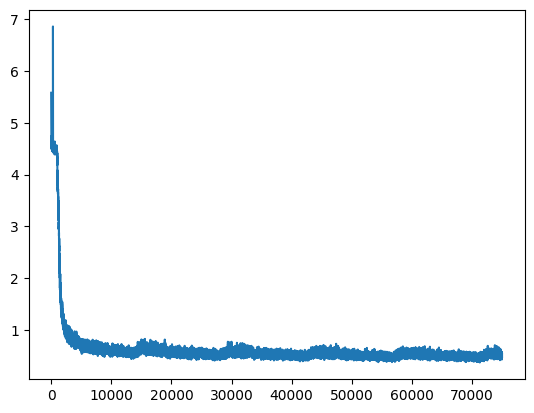

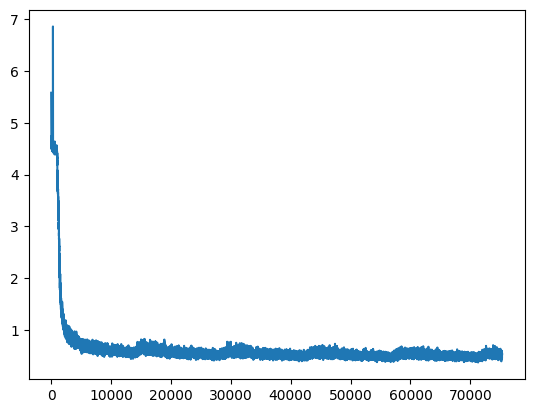

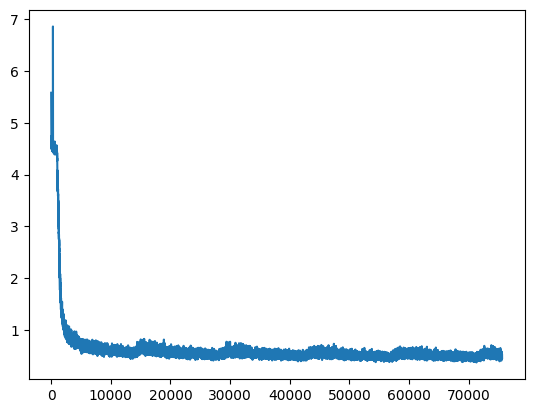

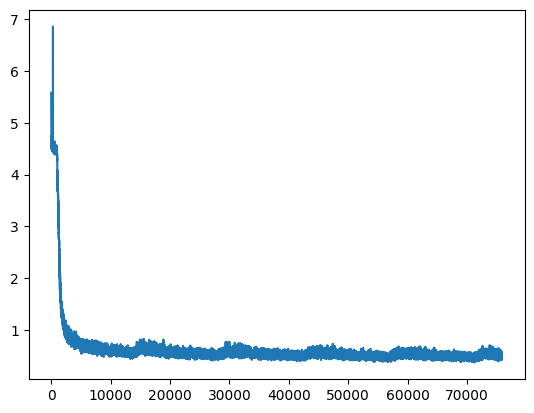

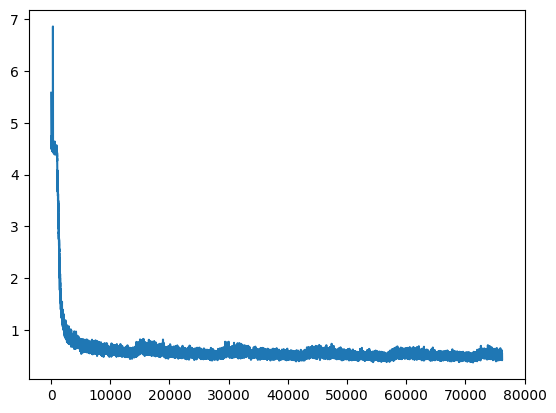

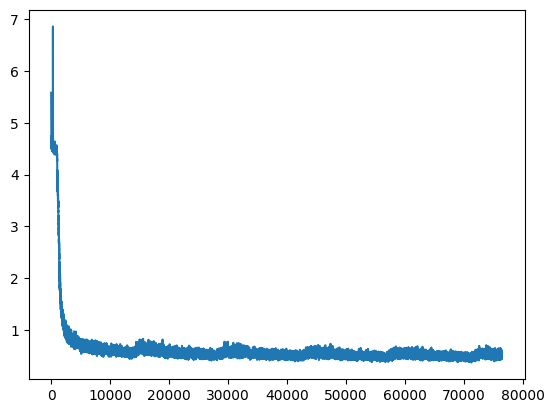

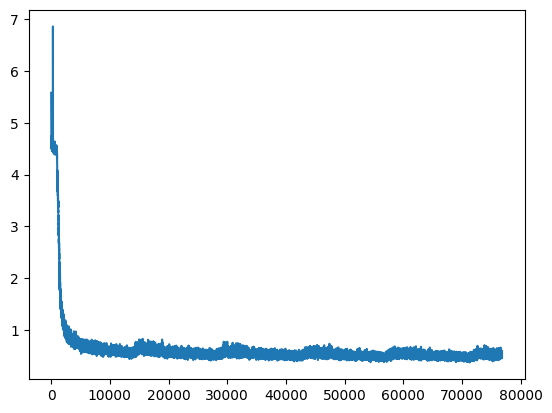

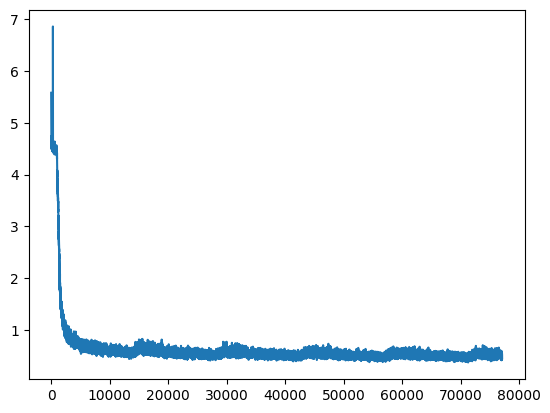

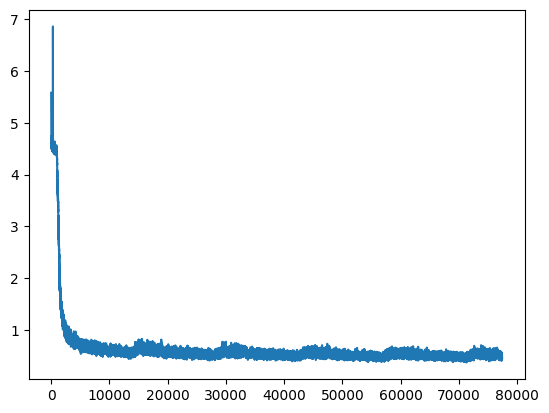

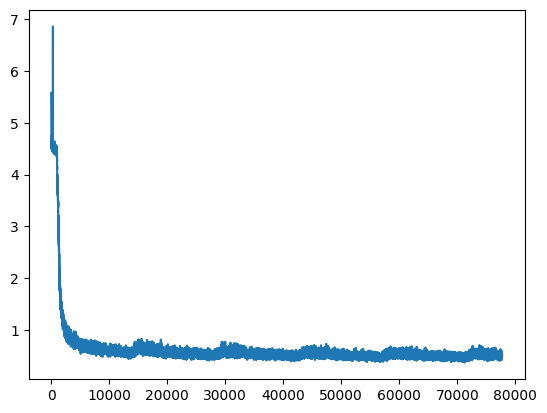

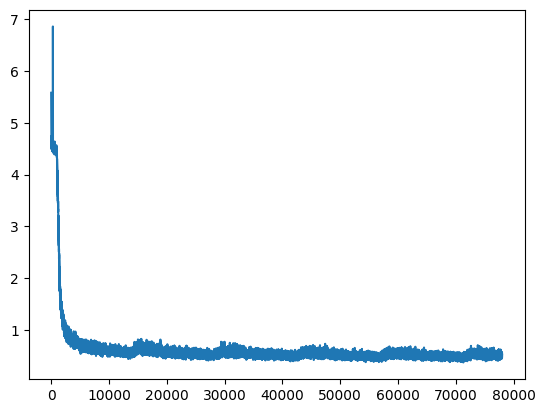

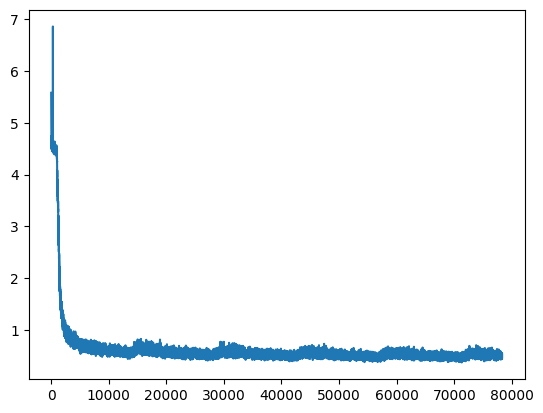

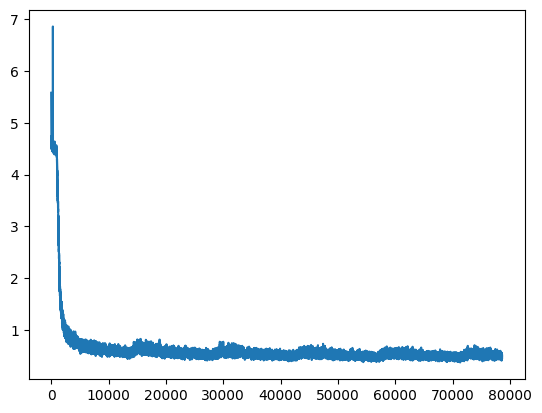

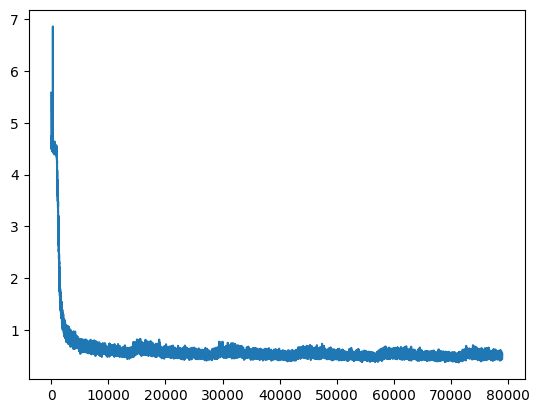

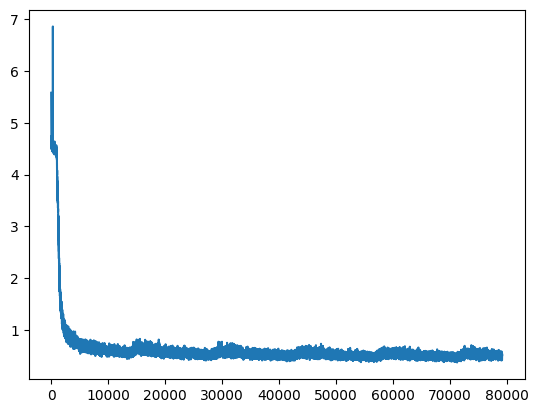

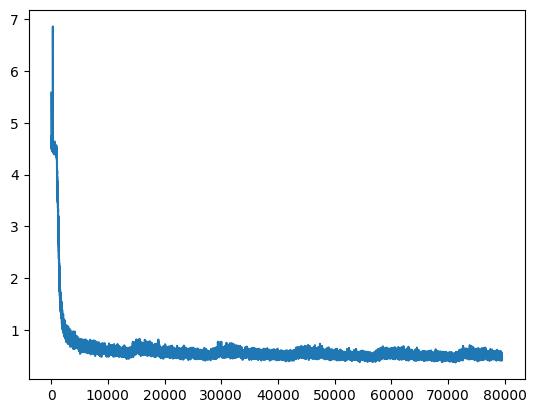

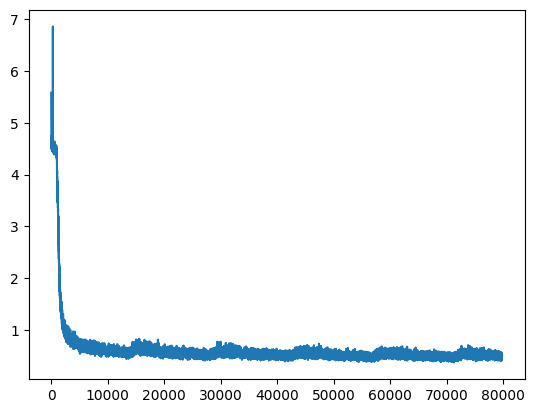

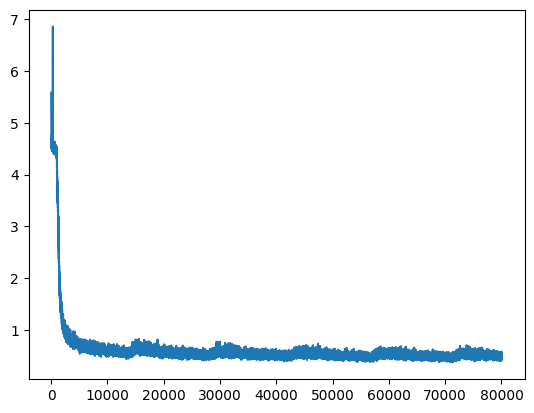

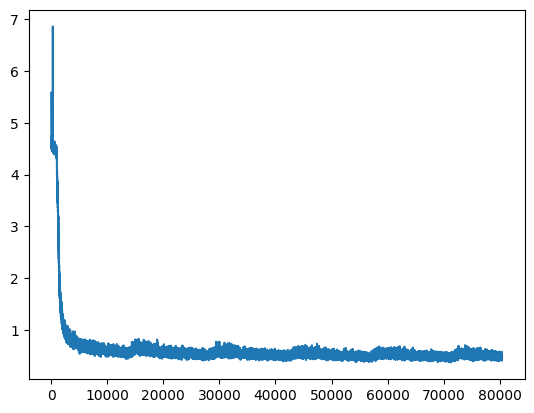

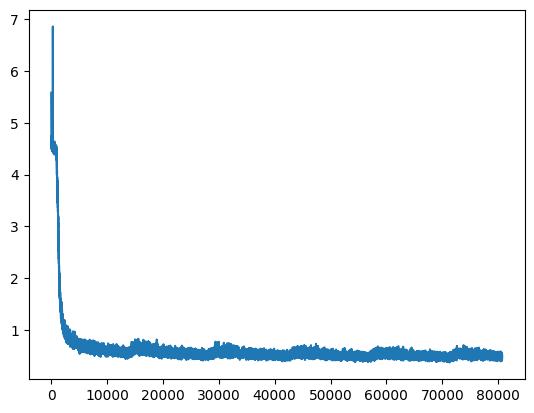

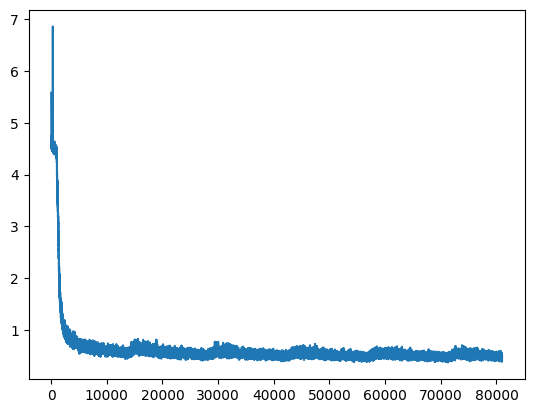

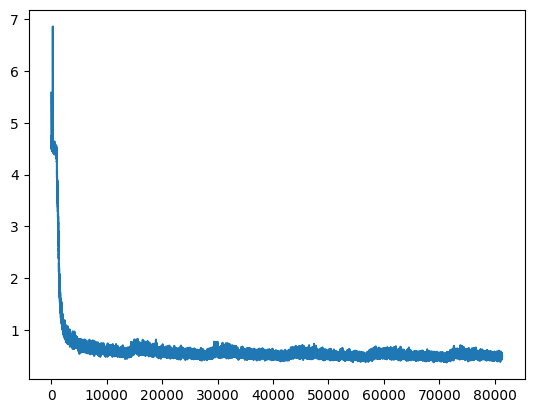

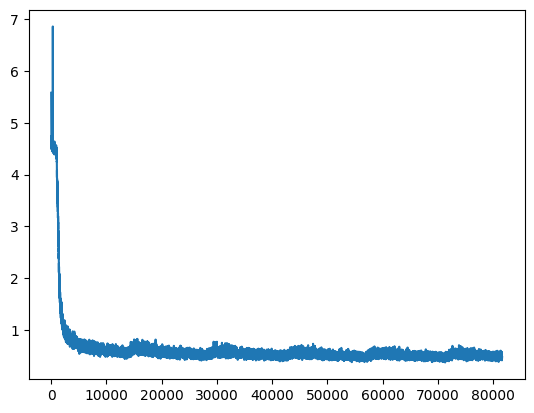

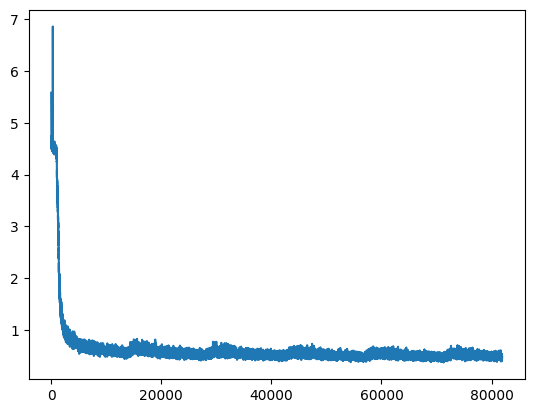

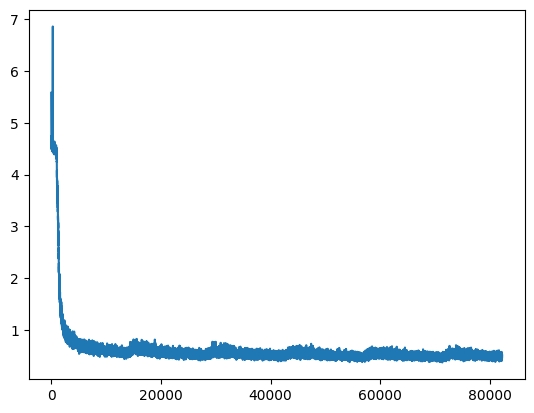

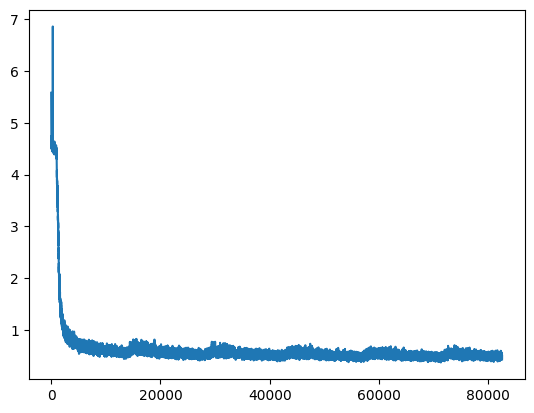

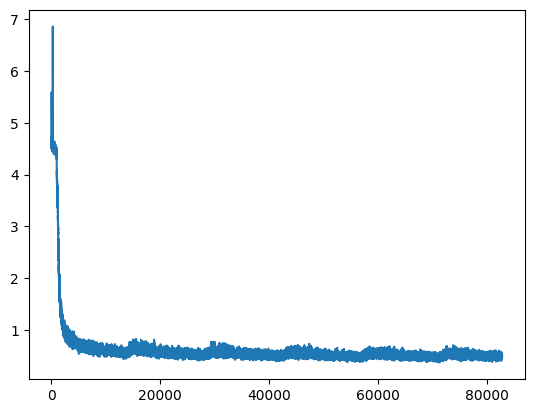

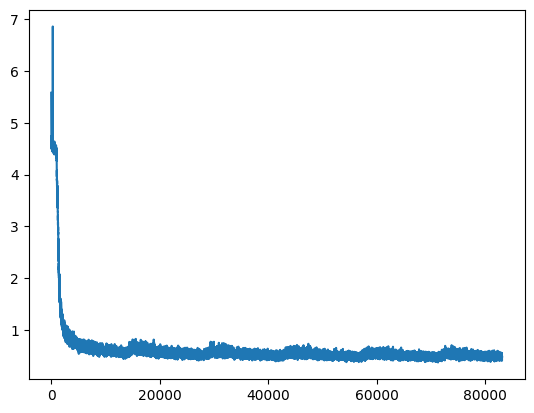

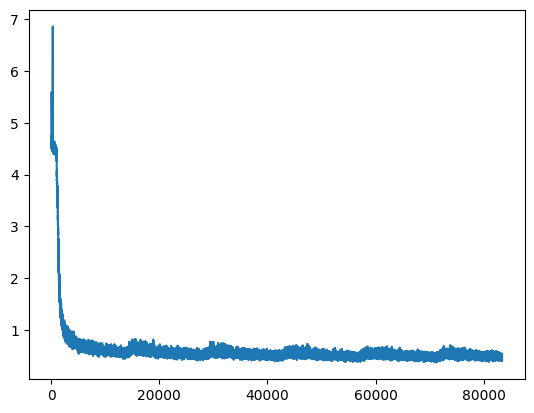

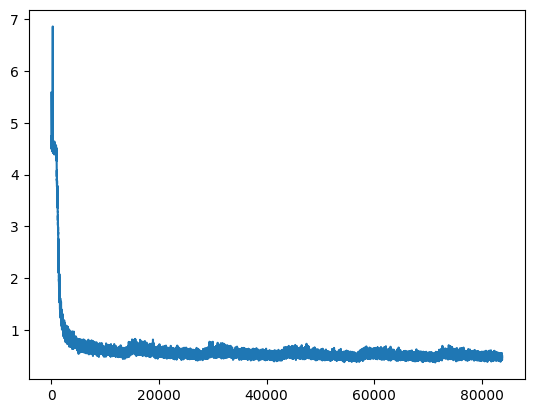

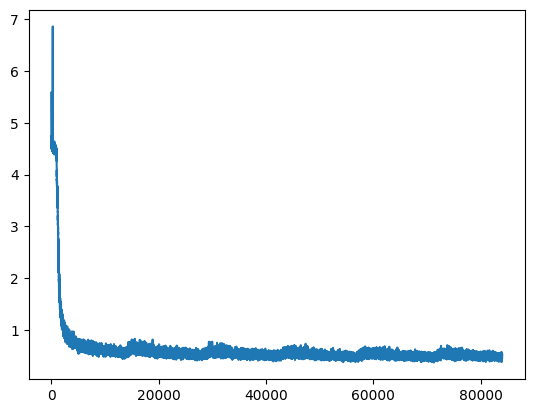

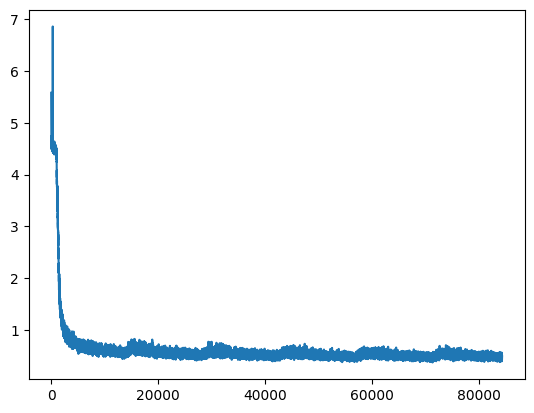

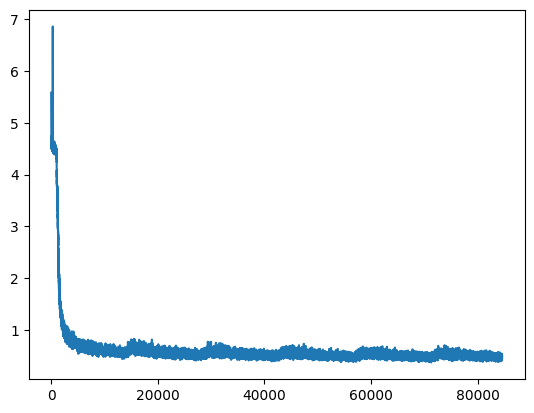

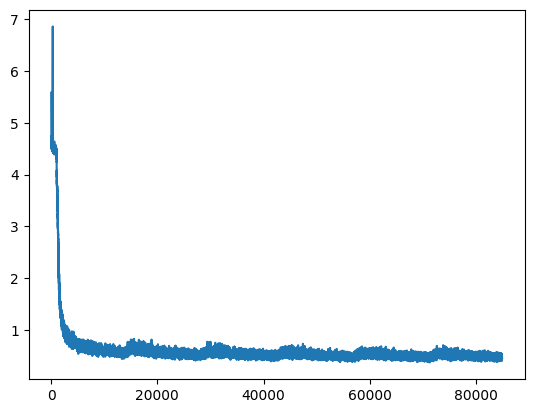

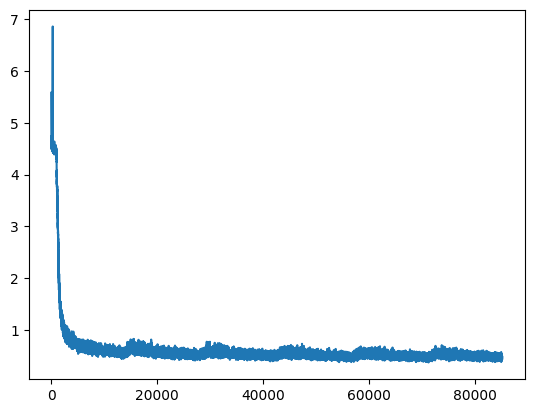

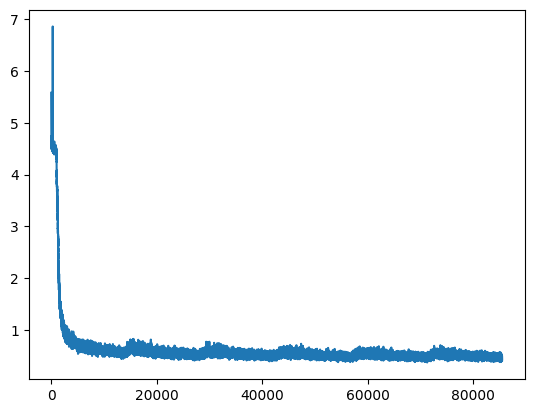

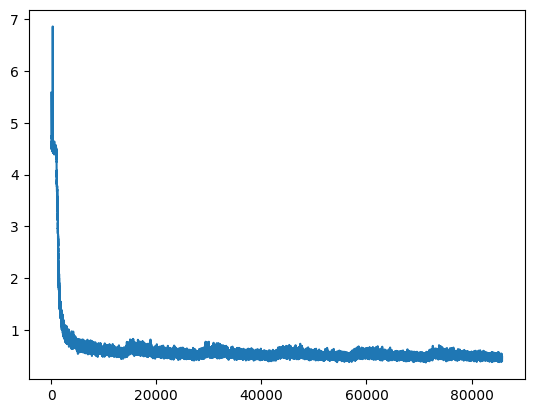

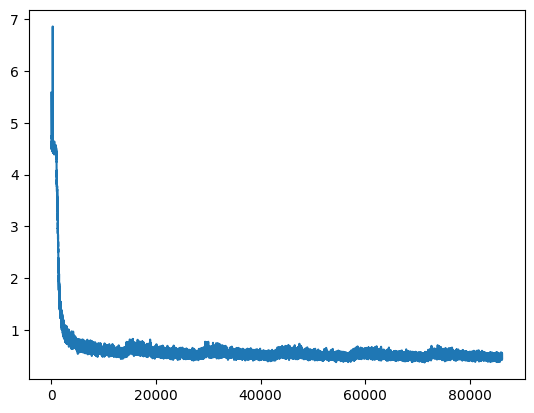

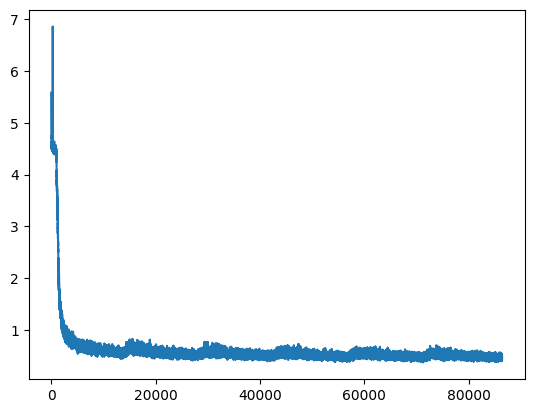

In [7]:
### Train the network on various saved games:    
load_dir = os.path.join(Path.cwd(), 'saved_games', 'v3', 'train')
save_paths = os.listdir(load_dir)

### Training parameters:
is_augment = True
epoch_list = [300, 300, 300]
batch_size_list = [512, 512, 512]
is_include_policy = True
is_plot_losses = False
learning_rate_list = [2e-3, 1e-3, 3e-4]

### Iterate over all data sets:
for _ in range(3):
    for _epoch, _bsize, _lr in zip(epoch_list, batch_size_list, learning_rate_list):
        print(f"\n{_epoch=}, {_bsize=}, {_lr=}\n")
        
        for _path in save_paths:
            print(_path)
            
            data_location = os.path.join(load_dir, _path)
            
            my_trainer.train(data_location=data_location,
                             is_augment=is_augment,
                             epochs=_epoch,
                             batch_size=_bsize,
                             is_include_policy=is_include_policy,
                             is_plot_losses=is_plot_losses,
                             learning_rate=_lr,
                             is_mask_policy=False,
                            )
            
            fig, ax = plt.subplots()
            ax.plot(my_trainer.losses)
    
    ### Save the network after training iterations finish:
    save_string = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
    save_path = os.path.join(Path.cwd(), 'saved_networks', 'v3', save_string + '.pt')
    torch.save(my_network.state_dict(), save_path)

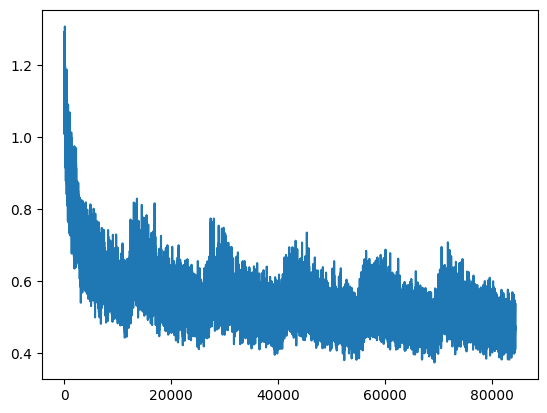

In [8]:
fig, ax = plt.subplots()
ax.plot(my_trainer.losses[2000:])

In [ ]:
### load a network and assess the accuracy

# save location for the state dictionary:
npaths = ["2025_07_02_17_49",
          "2025_07_02_19_04",
          "2025_07_03_12_18",
          "2025_07_03_13_28",
          "2025_07_03_15_17",
          "2025_07_03_16_37",
          "2025_07_03_17_44",
          "2025_07_03_21_08",
          "2025_07_03_22_57",
          "2025_07_04_13_54"
         ]

# todo need some way to get the meta characteristics in a file so that can always be loaded if the 
# architecture changes:

# path locations:
nlocs = [os.path.join(Path.cwd(), 'saved_networks', network_path + '.pt') for network_path in npaths]

# create shell networks:
nets = [PatternsNet(in_channels=47, out_channels=128) for _ in npaths]

# populate each network with different saved instance:
for _net, _nloc in zip(nets, nlocs):
    _net.load_state_dict(torch.load(_nloc, weights_only=True))

# assign to trainer class: (do we want to avoid assigning the network?)
ts = [PatternTrainer(network=_net, device=my_device) for _net in nets]

# string and data path for the validation games:
valid_path = "VALID_2025_07_02_07_57.pkl"
dloc = os.path.join(Path.cwd(), 'saved_games', valid_path)

# assess the losses for the network in question:
for _t in ts:
    _win_acc, _loss_acc, _draw_acc = _t.validate_value(data_location=dloc,
                                                       num_check=2000,
                                                       is_augment=True,
                                                       is_plot=True)
    
    print(_win_acc, _loss_acc, _draw_acc)


In [ ]:
fig, ax = plt.subplots()
ax.plot(my_trainer.losses)

In [ ]:
fig, ax = plt.subplots()
ax.set_ylim([0., 0.55])
ax.plot(my_trainer.losses)

In [ ]:
load_strings = ["2025_06_05_09_26", "2025_06_05_14_15", "2025_06_05_19_20"]

network_load_locations = [os.path.join(Path.cwd(), 'saved_networks', _ls + '.pt') for _ls in load_strings]

nets = [PatternsNet(in_channels=103, out_channels=128) for _ in range(len(load_strings))]

for net, load_location in zip(nets, network_load_locations):
    net.load_state_dict(torch.load(load_location, weights_only=True))

validation_data_location = os.path.join(Path.cwd(), 'saved_games', '2025_05_30_11_27.pkl')

vtrainers = [PatternTrainer(network=_net, device=my_device) for _net in nets]

In [ ]:
for _vt in vtrainers:
    _win_acc, _loss_acc, _draw_acc = _vt.validate_value(data_location=validation_data_location,
                                                        num_check=2000,
                                                        is_augment=True,
                                                        is_plot=True)
    print(_win_acc, _loss_acc, _draw_acc)


In [ ]:
win1, loss1, draw1 = vtrainer1.validate_value(data_location=validation_data_location,
                                              num_check=2000,
                                              is_augment=True,
                                              is_plot=True)


In [ ]:
win1, win2, loss1, loss2, draw1, draw2

In [ ]:
# set network to eval mode:
validation_trainer.network.eval()

# split the data set:
wins = validation_games[1]
losses = validation_games[-1]
draws = validation_games[0]

In [ ]:
predictions = []
num_required = 1000
game_list = wins
batch_size = 2048
is_augment = True

while len(predictions) < num_required:
    print('HI')
    # collect sample of games:
    sample_games = game_list[:batch_size]

    # get the states from the games:
    _states, _vcs, _, _, _ = zip(*sample_games)

    # stack the tensors:
    state_tensor = torch.stack(_states)
    vc_tensor = torch.tensor(np.stack(_vcs))

    # augment the states:
    states, visit_counts = validation_trainer.augment_sample(state_tensor, vc_tensor, is_augment=is_augment)

    # get the predicted results and the policy vectors for the states considered:
    with torch.no_grad():
        # do not collect the prior policy here:
        value_predictions, _ = validation_trainer.network(states.to(validation_trainer.device))

    # return the value predictions locally:
    predictions.append(value_predictions.cpu())

    # trim the wins list:
    game_list = game_list[batch_size:]

    if batch_size * num_required >= num_required:
        break


In [ ]:

# turn the list of tensors into a single tensor:
predictions = torch.stack(predictions)

In [ ]:
len(game_list), num_required

In [ ]:
win_accuracy = ((win_predictions.numpy() - 1.0) ** 2.0).sum() ** 0.5 / len(win_predictions)
loss_accuracy = ((loss_predictions.numpy() - 1.0) ** 2.0).sum() ** 0.5 / len(loss_predictions)
draw_accuracy = ((draw_predictions.numpy() - 1.0) ** 2.0).sum() ** 0.5 / len(draw_predictions)

In [ ]:
import numpy as np

In [ ]:
my_args = np.argsort(np.random.rand(5))[:3]
my_args

In [ ]:
np.random.sample([0, 1, 2, 3, 4], k=2)

In [ ]:
import torch

my_arr = torch.zeros((8, 8, 12), dtype=float)

active_order = [0, 0, 1, 3, 2, 4]
passive_order = [3, 0, 1, 0, 0, 2]

vals = torch.tensor(active_order + passive_order, dtype=float) / 6.0

# inds = np.array(range(12))
inds = range(12)

my_arr[:, :, inds] = vals



In [ ]:
my_arr[:, :, 3]

In [ ]:
d1 = {1: [1, 2, 3], 2: [4, 5, 6]}

d2 = dict(d1)
d3 = {_key: _val[:] for _key, _val in d1.items()}

d2[1].append(0)
d2[1][0] *= 1000

d3[2].append(7)
d3[2][0] *= 10

d1, d2, d3

In [ ]:
jim = np.array([0, 1, 2, 3, 4, 5, 6])

peack = jim / 6.

for _ in peack:
    print(round(_ * 6))